# Evaluation on Kang Data

In [1]:
# %load_ext nb_black
%load_ext autoreload
%autoreload 2

In [2]:
import anndata as ad
import numpy as np
import pandas as pd
from sklearn.metrics import average_precision_score, precision_recall_fscore_support
# import benchmark as bm
from prismo import feature_sets as fs
import matplotlib.pyplot as plt
import seaborn as sns
import pathlib
import os
from plotnine import *
import pandas as pd
from sklearn.metrics import roc_auc_score
import scanpy as sc


%matplotlib
%matplotlib inline

/data/m015k/miniconda3/envs/prismo/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.

Using matplotlib backend: module://matplotlib_inline.backend_inline


/data/m015k/miniconda3/envs/prismo/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
/data/m015k/miniconda3/envs/prismo/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
/data/m015k/miniconda3/envs/prismo/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
/data/m015k/miniconda3/envs/prismo/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
/data/m015k/miniconda3/envs/prismo/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_mtx from `anndata` is deprecated. Import anndata.io.read_mtx instead.
/data/m015k/miniconda3/envs/prismo/lib/python3.10/site-packages/

In [ ]:
device = "cuda"
seed = 2411111440
rng = np.random.default_rng(seed)

# Discrete colors
colors_disc = [
    "#FF9999",
    "#66B2FF",
    "#99FF99",
    "#FFCC99",
    "#FF99CC",
    "#99CCFF",
    "#FF6666",
    "#66CC00",
]
# Continuous colors
colors_div = ["#214D83", "#7D1B26"]  # blue, red

In [ ]:
VS_CODE_REMOTE = True
if VS_CODE_REMOTE:
    os.chdir(pathlib.Path().absolute() / "benchmark")
    import benchmark as bm
    import plotting

/data/m015k/miniconda3/envs/prismo/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
/data/m015k/miniconda3/envs/prismo/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
/data/m015k/miniconda3/envs/prismo/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
/data/m015k/miniconda3/envs/prismo/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing CSCDataset from `anndata.experimental` is deprecated. Import anndata.abc.CSCDataset instead.
/data/m015k/miniconda3/envs/prismo/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing CSRDataset from `anndata.experimental` is deprecated. Import anndata.abc.CSRDataset instead.
/data/m015k/miniconda3/envs/pr

In [5]:
adata = ad.read_h5ad("../data/kang_tutorial.h5ad").copy()
adata.var_names = adata.var_names.str.upper()
adata._inplace_subset_var(adata.to_df().std() > 0.2)

gene_set_collection = fs.from_gmt("../msigdb/c2.cp.reactome.v7.5.1.symbols.gmt")
# gene_set_collection = fs.from_gmt("top_overlap_dict_at_500.gmt")
# gene_set_collection = fs.from_gmt("../msigdb/h.all.v7.5.1.symbols.gmt")
gene_set_collection = gene_set_collection.filter(
    adata.var_names,
    min_fraction=0.4,
    min_count=40,
    max_count=200,
    # adata.var_names, min_fraction=0.1, min_count=5
)
print(gene_set_collection)

true_mask = gene_set_collection.to_mask(adata.var_names.tolist())
# true_mask = pd.read_csv('../data/common_mask_hallmark.csv', index_col=0)
terms = true_mask.index.tolist()

true_mask = true_mask.values
noisy_mask = bm.get_rand_noisy_mask(rng, true_mask, fpr=0.3, fnr=0.3)

<FeatureSets 'c2.cp.reactome.v7.5.1.symbols.gmt' with 120 feature sets>


In [6]:
average_precision_score((true_mask).flatten(), noisy_mask.flatten())

0.5043563427464821

In [7]:
precision_recall_fscore_support((true_mask).flatten(), noisy_mask.flatten())

(array([1.  , 0.71]),
 array([1.  , 0.71]),
 array([1.  , 0.71]),
 array([510538,   8462]))

### Preprocessing

In [8]:
x = adata.X
x = x - x.min(axis=0)
log_x = np.log1p(x)
log_x = log_x / log_x.std()
log_x_centered = log_x - log_x.mean(axis=0)
log_x_stdised = log_x_centered / log_x_centered.std()

data_dict = {
    "expimap": log_x_centered.astype(np.float32),
    "expimap_nb": x.astype(np.float32),
    "expimap_hardmask": log_x_centered.astype(np.float32),
    "expimap_hardmask_nb": x.astype(np.float32),
    "spectra": log_x.astype(np.float32),
    "prismo": log_x_centered.astype(np.float32),
    "prismo_nmf": log_x.astype(np.float32),
}

### Train Expimap

In [9]:
model_dict = {}

for soft_mask in [True]:
    for recon_loss in ["mse"]:
        model_name = "expimap"
        if not soft_mask:
            model_name += "_hardmask"
        if recon_loss == "nb":
            model_name += "_nb"
        # model_name = f"{model_name}_{alpha_l1}"
        data_name = data_dict[model_name.split("_")[0]]
        model_dict[model_name] = bm.train_expimap(
            data_name,
            noisy_mask,
            seed=seed,
            terms=terms,
            recon_loss=recon_loss,
            # alpha_l1=alpha_l1,
            n_epochs=1000,
            batch_size=1000,
            soft_mask=soft_mask,
            hidden_size_1=512,
            hidden_size_2=256,
        )


INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 4325 512 1
	Hidden Layer 1 in/out: 512 256
	Mean/Var Layer in/out: 256 120
Decoder Architecture:
	Masked linear layer in, ext_m, ext, cond, out:  120 0 0 1 4325
	with soft mask.
Last Decoder layer: identity
The default value of alpha_kl was changed to 0.35. from 1. This may case inconsistency with previous training results. Set alpha_kl=1. to reproduce the previous results.
alpha_epoch_anneal is used by default now. This may case inconsistency with previous training results. Set alpha_epoch_anneal=None to reproduce the previous results.
Preparing (13576, 4325)
Instantiating dataset
 |██------------------| 14.8%  - epoch_loss: 1498.8003962590 - epoch_recon_loss: 1438.0472412109 - epoch_kl_loss: 173.5804384672 - val_loss: 1494.2493896484 - val_recon_loss: 1433.0444946289 - val_kl_loss: 174.8711395264
ADJUSTED LR
 |███-----------------| 17.4%  - epoch_loss: 1478.2741980919 - epoch_recon_loss: 1417

### Train Sepctra

In [10]:
model_dict["spectra"] = bm.train_spectra(
    data_dict["spectra"], noisy_mask, terms=terms, num_epochs=1000
)

100%|██████████| 1000/1000 [10:39<00:00,  1.56it/s]


### Train PRISMO

In [11]:
for model_name in ["prismo", "prismo_nmf"]:  #
    nmf = ("nmf" in model_name) or ("nb" in model_name)
    # for prior_confidence in [0.99, 0.999]:
    # model_dict[f"{model_name}-{prior_confidence}"] = muvi.bm.train_muvi(
    prior_penalty = 0.005
    # model_dict[f"{model_name}_{max_epochs}"] = bm.train_prismo(
    model_dict[model_name] = bm.train_prismo(
        data_dict[model_name],
        noisy_mask,
        seed=seed,
        terms=terms,
        obs_names=adata.obs_names.copy(),
        var_names=adata.var_names.copy(),
        n_factors=3,
        nmf=nmf,
        prior_penalty=prior_penalty,
        max_epochs=10000,
        batch_size=0,
        n_particles=1,
        lr=0.003,
        early_stopper_patience=100,
        device=device,
        true_mask=true_mask,
    )

# muvi.save(model_dict["muvi"], "benchmark_data_muvi_model")
# model_dict["muvi"] = muvi.load("benchmark_data_muvi_model")

2024-11-13 10:37:37 | prismo.prismo | INFO | Setting up device...
INFO:prismo.prismo:Setting up device...
2024-11-13 10:37:37 | prismo.prismo | INFO | - Checking compatibility of provided likelihoods with data.
INFO:prismo.prismo:- Checking compatibility of provided likelihoods with data.
2024-11-13 10:37:37 | prismo.prismo | INFO |   - view_0: Normal
INFO:prismo.prismo:  - view_0: Normal
2024-11-13 10:37:40 | prismo.prismo | INFO | Initializing factors using `random` method...
INFO:prismo.prismo:Initializing factors using `random` method...
2024-11-13 10:37:40 | prismo.prismo | INFO | Decaying learning rate over 10000 iterations.
INFO:prismo.prismo:Decaying learning rate over 10000 iterations.
2024-11-13 10:37:40 | prismo.prismo | INFO | Setting training seed to `2411111440`.
INFO:prismo.prismo:Setting training seed to `2411111440`.
2024-11-13 10:37:40 | prismo.prismo | INFO | Cleaning parameter store.
INFO:prismo.prismo:Cleaning parameter store.
2024-11-13 10:37:40 | prismo.prismo | 

In [ ]:
model = model_dict["prismo"]

for k in model_dict:
    if "prismo" not in k:
        continue
    model_dict[k].factor_order = np.arange(model_dict[k].model_opts.n_factors)
    model_dict[k]._factor_order = np.arange(model_dict[k].model_opts.n_factors)
    model_dict[k].sample_names["group_1"] = adata.obs_names.tolist()
    model_dict[k].feature_names["view_0"] = adata.var_names.tolist()

# define order of dict keys
model_dict = {
    "expimap": model_dict["expimap"],
    "spectra": model_dict["spectra"],
    "prismo": model_dict["prismo"],
    "prismo_nmf": model_dict["prismo_nmf"],
}

### Compute Metrics

In [13]:
print("AUPR")
per_factor_aupr = {}
top = 200
for k, model in model_dict.items():
    per_factor_aupr[k] = bm.get_average_precision(
        true_mask, model, per_factor=True, top=top
    )
    print(k, bm.get_average_precision(true_mask, model, top=top))

print("BINARY")
per_factor_prec = {}
per_factor_rec = {}
per_factor_f1 = {}
threshold = None
opt_thresh_dict = {}
for k, model in model_dict.items():
    prec, rec, f1, opt_thresh = bm.get_binary_scores(
        true_mask, model, threshold=threshold, per_factor=True, top=top
    )
    opt_thresh_dict[k] = opt_thresh
    per_factor_prec[k] = prec
    per_factor_rec[k] = rec
    per_factor_f1[k] = f1
    print(k, bm.get_binary_scores(true_mask, model, threshold=opt_thresh, top=top))

AUPR
expimap 0.05049048068243747


/data/m015k/miniconda3/envs/prismo/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
/data/m015k/miniconda3/envs/prismo/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
/data/m015k/miniconda3/envs/prismo/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
/data/m015k/miniconda3/envs/prismo/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.


spectra 0.39685389536286136
prismo 0.32665201939502997
prismo_nmf 0.40784014459318
BINARY
best threshold: 0.08288785815238953
expimap (0.05236260712320151, 0.586784140969163, 0.09614551754006063, 0.08288786)


/data/m015k/miniconda3/envs/prismo/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
/data/m015k/miniconda3/envs/prismo/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
/data/m015k/miniconda3/envs/prismo/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
/data/m015k/miniconda3/envs/prismo/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this be

best threshold: 0.006721463054418564
spectra (0.42717232756824336, 0.48774684748988817, 0.45545434347922686, 0.006721463)


/data/m015k/miniconda3/envs/prismo/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
/data/m015k/miniconda3/envs/prismo/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
/data/m015k/miniconda3/envs/prismo/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


best threshold: 0.05405620113015175
prismo (0.22909366417274363, 0.6571583808747623, 0.33974719101123596, 0.0540562)
best threshold: 0.28057295083999634
prismo_nmf (0.45067160722556737, 0.4919110212335693, 0.4703891708967851, 0.28057295)


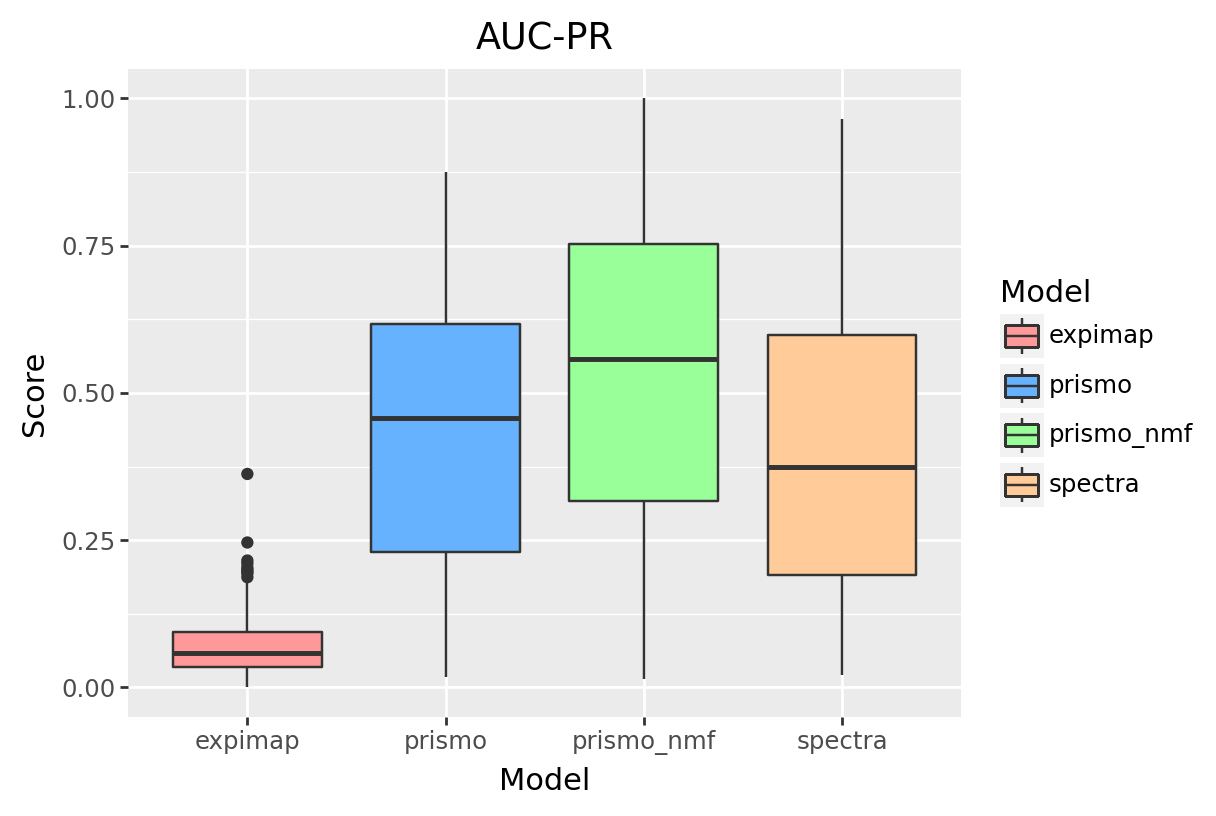

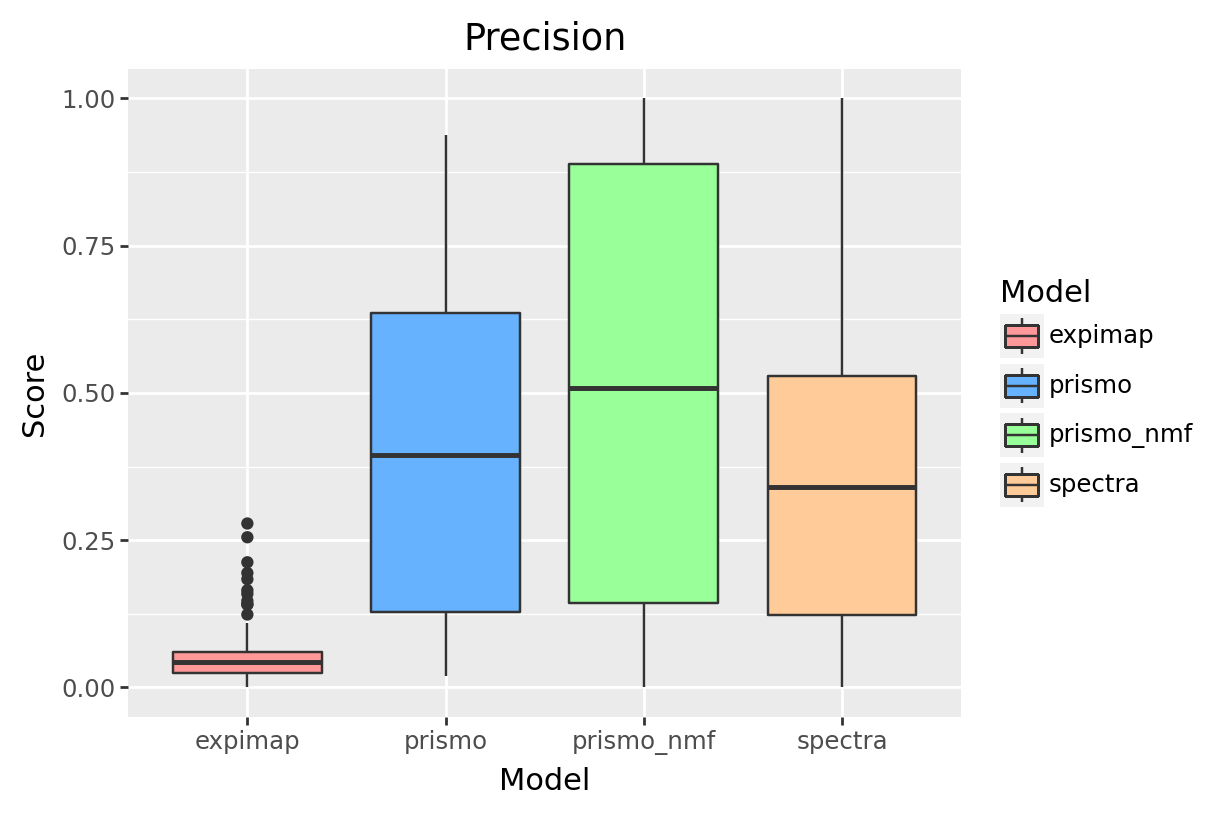

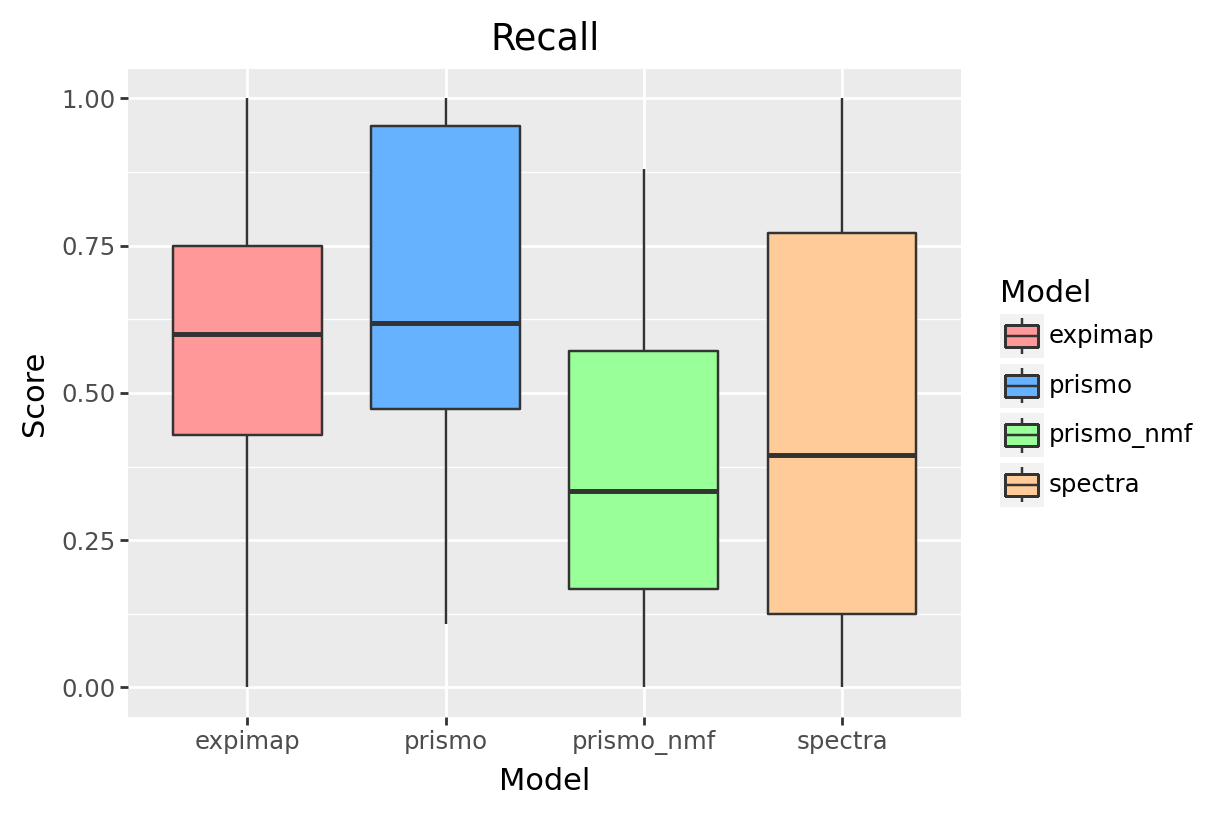

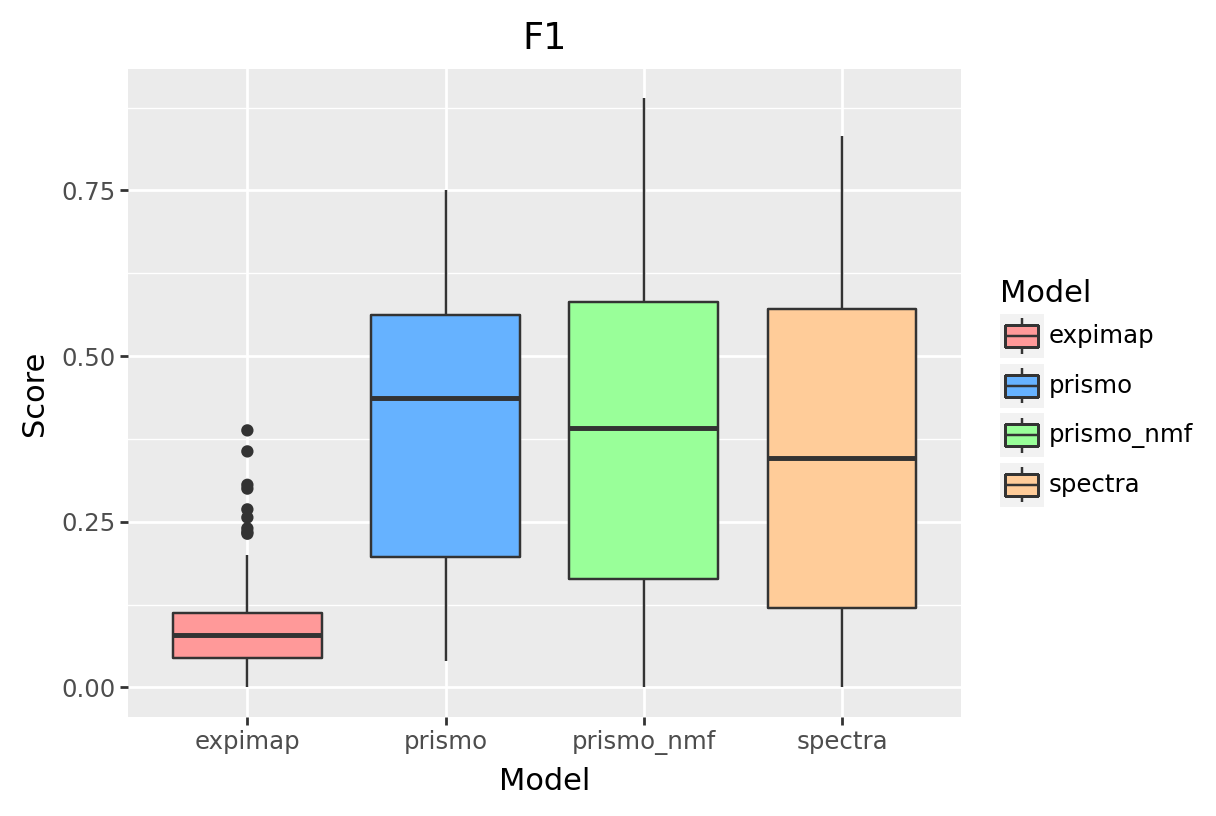

In [ ]:
score_df_dict = {
    "AUC-PR": pd.DataFrame(per_factor_aupr),
    "Precision": pd.DataFrame(per_factor_prec),
    "Recall": pd.DataFrame(per_factor_rec),
    "F1": pd.DataFrame(per_factor_f1),
}


def plot_scores(
    score_df_dict,
    model_names=None,
    model_labels=None,
    ylim=None,
    boxplot_kwargs={},
    xticklabels_kwargs={},
):
    for score_name, score_df in score_df_dict.items():
        if model_names is not None:
            score_df = score_df.loc[:, model_names]

        df_long = score_df.melt(var_name="Model", value_name="Score")
        df_long["Metric"] = score_name

        p = (
            ggplot(df_long, aes(x="Model", y="Score", fill="Model"))
            + geom_boxplot(**boxplot_kwargs)
            + labs(title=score_name)
            + scale_fill_manual(values=colors_disc[: len(score_df.columns)])
            + theme(axis_text_x=element_text(**xticklabels_kwargs), figure_size=(6, 4))
        )

        if ylim is not None:
            p = p + ylim(ylim[0], ylim[1])

        if model_labels is not None:
            p = p + scale_x_discrete(labels=model_labels)

        p.show()


plot_scores(score_df_dict)

In [15]:
score_df_dict["AUC-PR"].median()

expimap       0.059059
spectra       0.374267
prismo        0.457185
prismo_nmf    0.558107
dtype: float64

In [16]:
model_scores = {}
for k, model in model_dict.items():
    model_scores[k] = []
    data_name = k.split("-")[0]
    if "expimap" in k:
        data_name = k.split("_")[0]

    data = data_dict[data_name]
    if "famo" in k:
        data = model.data["group_1"]["view_0"].X
    # model_scores[k].append(bm.get_rmse(model, model.data["group_1"]["view_0"].X))
    model_scores[k].append(bm.get_rmse(model, data))
    # model_scores[k].append(muvi.bm.get_average_precision(true_mask, model, top=200))
    model_scores[k].append(pd.DataFrame(per_factor_aupr).median()[k])
model_scores

{'expimap': [0.5311428, 0.05905857368328306],
 'spectra': [0.7409691, 0.37426653408177823],
 'prismo': [0.63084334, 0.4571854293400653],
 'prismo_nmf': [0.5511588, 0.5581072019008106]}

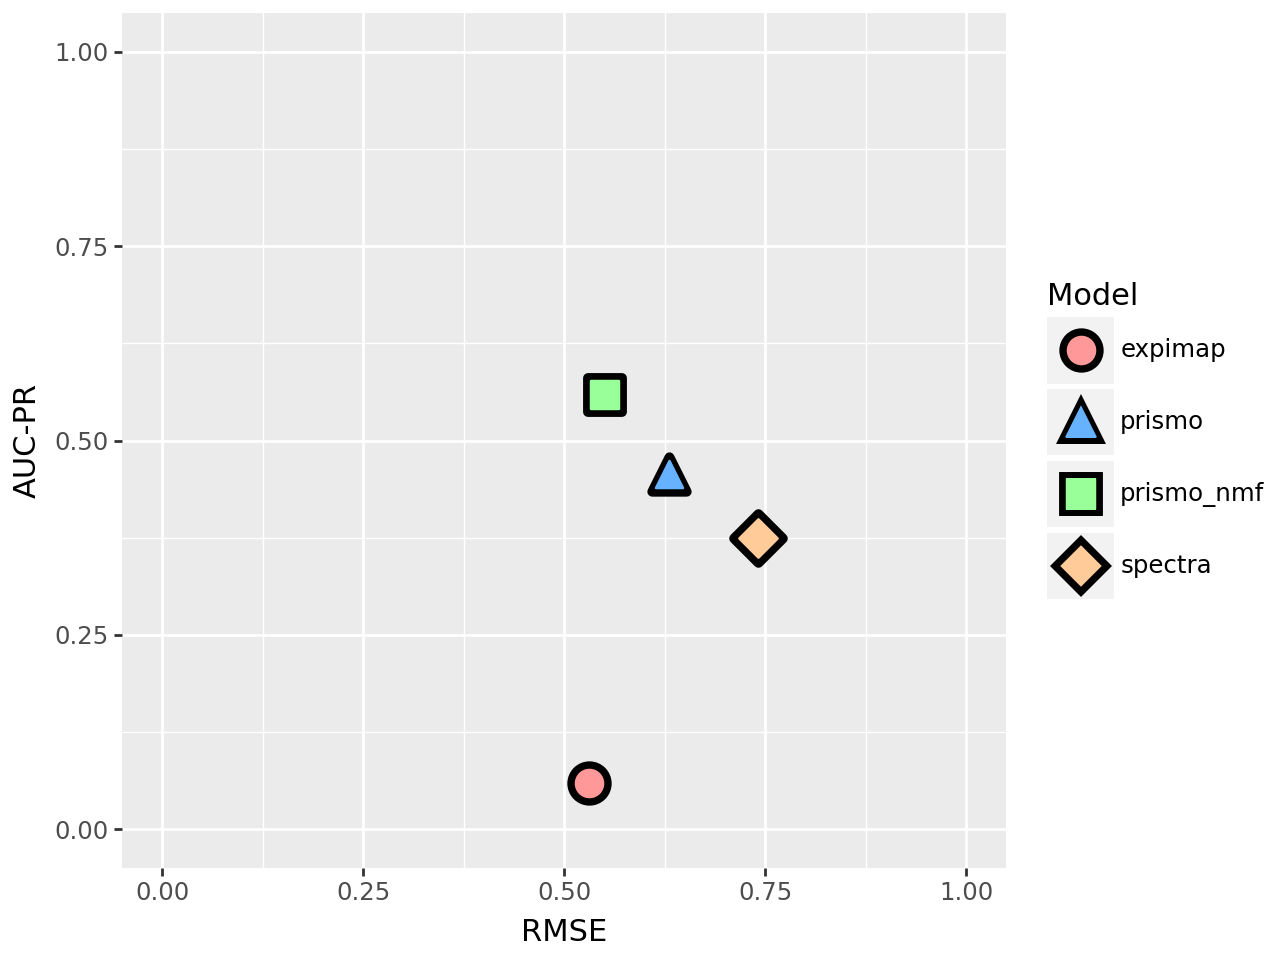

In [ ]:
# Create a DataFrame
df = pd.DataFrame(model_scores).T.copy()
df.columns = ["RMSE", "AUC-PR"]
df["Model"] = df.index.copy()

# Create the plotnine plot
plot = (
    ggplot(df, aes(x="RMSE", y="AUC-PR", color="Model", shape="Model"))
    + geom_point(size=5, stroke=2, color="black", fill=None)
    + geom_point(size=5)
    + scale_color_manual(values=colors_disc)
    + xlim(0.0, 1.0)
    + ylim(0.0, 1.0)
    + theme(legend_position="right")
)
plot

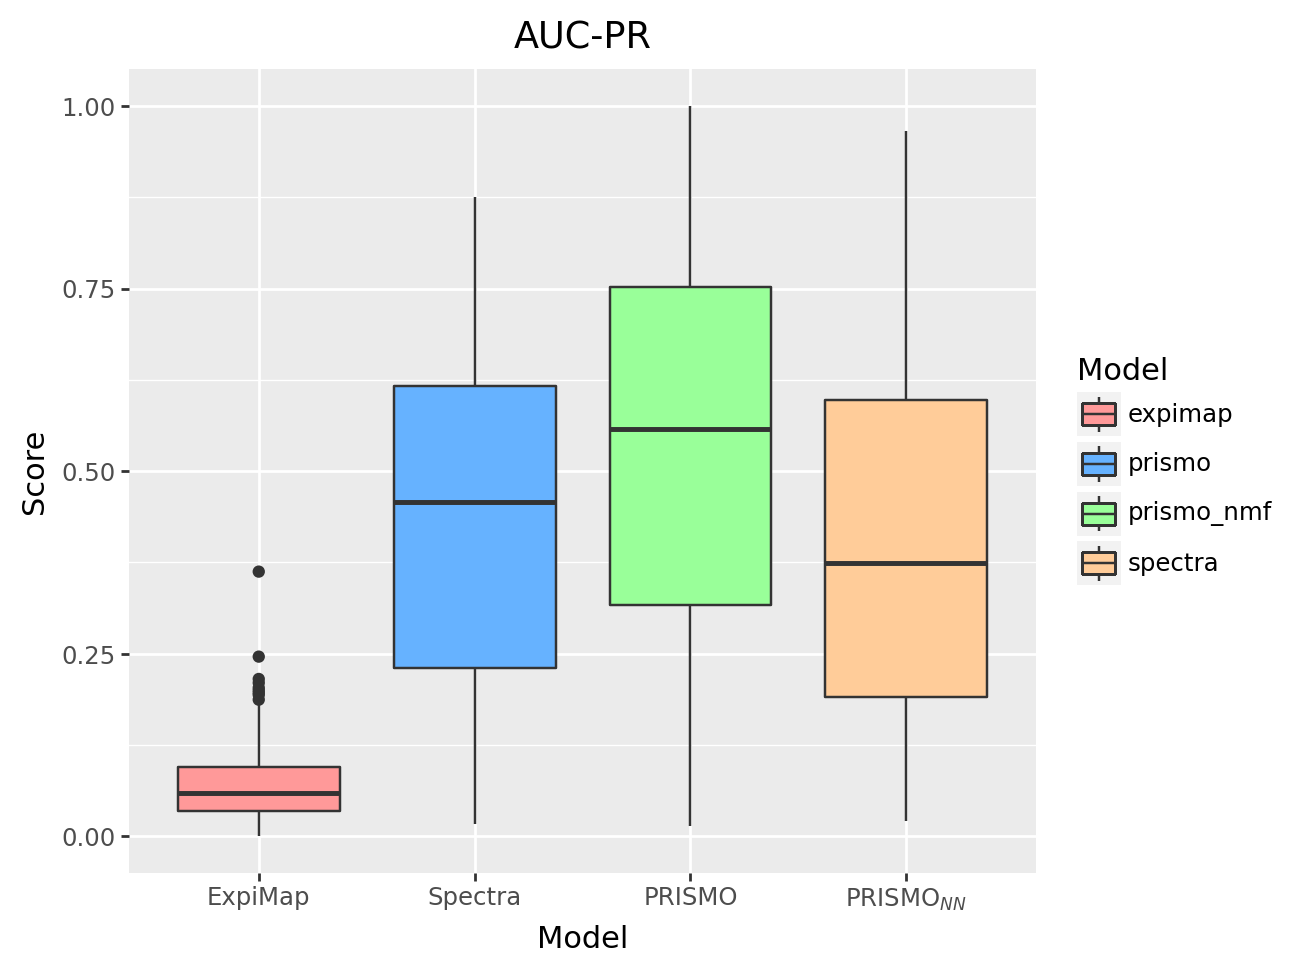

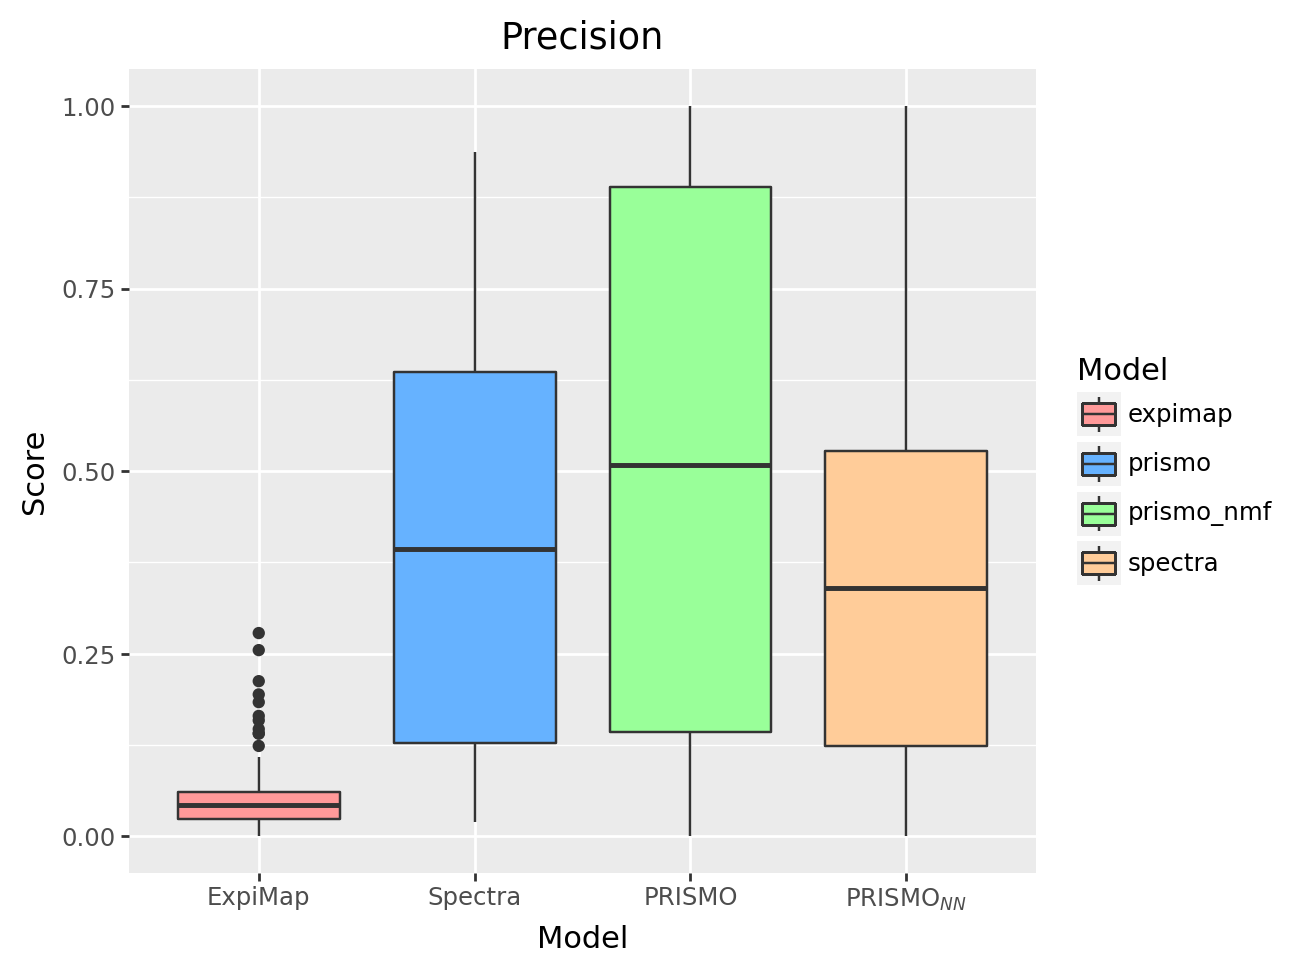

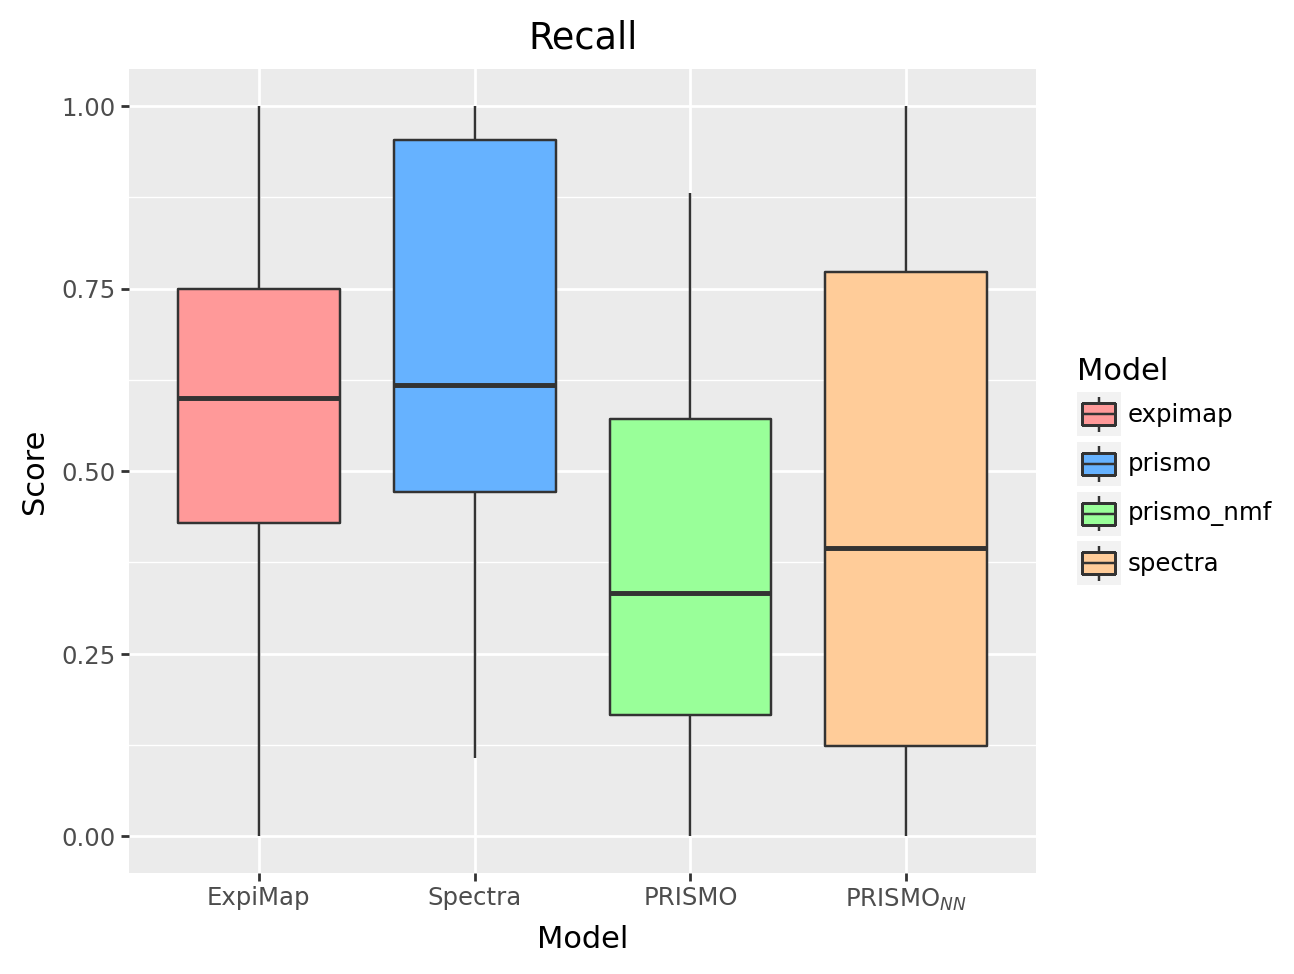

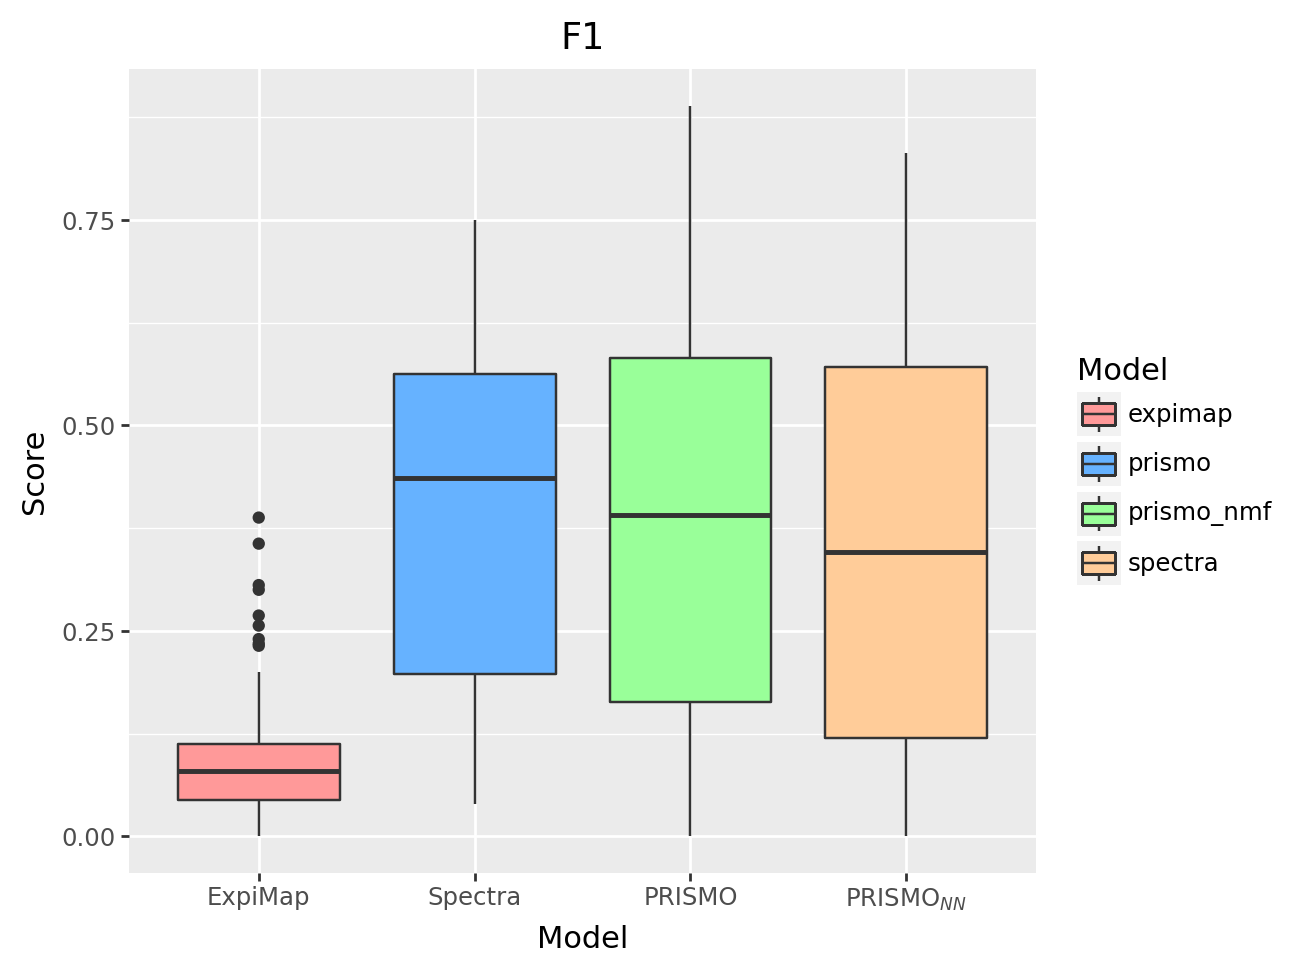

index       Model     Score
0        0     expimap  0.061856
1        1     expimap  0.086207
2        2     expimap  0.158730
3        3     expimap  0.166667
4        4     expimap  0.050633
..     ...         ...       ...
475    115  prismo_nmf  0.500000
476    116  prismo_nmf  0.000000
477    117  prismo_nmf  0.285714
478    118  prismo_nmf  0.571429
479    119  prismo_nmf  0.500000

[480 rows x 3 columns]

In [ ]:
model_names = ["expimap", "spectra", "prismo", "prismo_nmf"]
model_labels = ["ExpiMap", "Spectra", "PRISMO", "PRISMO$_{NN}$"]


def plot_scores(
    score_df_dict,
    model_names=None,
    model_labels=None,
    ylim=None,
    boxplot_kwargs={},
    xticklabels_kwargs={},
):
    for score_name, score_df in score_df_dict.items():
        if model_names is not None:
            score_df = score_df.loc[:, model_names]

        melted_df = pd.melt(
            score_df.reset_index(),
            id_vars=["index"],
            var_name="Model",
            value_name="Score",
        )

        p = (
            ggplot(melted_df, aes(x="Model", y="Score", fill="Model"))
            + geom_boxplot(**boxplot_kwargs)
            + ggtitle(score_name)
            + theme(axis_text_x=element_text(**xticklabels_kwargs))
        )

        if colors_disc is not None:
            p += scale_fill_manual(values=colors_disc)

        if ylim is not None:
            p += ylim(*ylim)

        if model_labels is not None:
            p += scale_x_discrete(labels=model_labels)

        p.show()

    return melted_df


plot_scores(score_df_dict, model_names, model_labels)

In [19]:
factor_loadings = {k: bm.get_factor_loadings(model) for k, model in model_dict.items()}
factor_loadings.keys()

dict_keys(['expimap', 'spectra', 'prismo', 'prismo_nmf'])

In [20]:
fn_sum = (true_mask & ~noisy_mask).sum(axis=1)

In [21]:
np.set_printoptions(precision=1)

In [22]:
idx_df = {}
tp_df = {}
tn_df = {}
fp_df = {}
fn_df = {}
for k, model in model_dict.items():
    idx, wh, tm, nm = bm.get_reconstruction_fraction(
        true_mask, noisy_mask, model, top=200
    )
    idx_df[k] = idx
    non_zero = np.abs(wh) > 0.0
    tp = tm & nm & non_zero
    tn = ~tm & ~nm & non_zero
    fp = ~tm & nm & non_zero
    fn = tm & ~nm & non_zero
    tp_df[k] = tp.sum(axis=1).tolist()
    tn_df[k] = tn.sum(axis=1).tolist()
    fp_df[k] = fp.sum(axis=1).tolist()
    fn_df[k] = fn.sum(axis=1).tolist()
    if len(k) < 5:
        k += "\t"
    print(
        k,
        "\t",
        "TP, FP, TN, FN",
        "\t",
        f"{tp.sum(axis=1).mean():2.2f}, {fp.sum(axis=1).mean():2.2f}, {tn.sum(axis=1).mean():2.2f}, {fn.sum(axis=1).mean():2.2f}",
    )
tp_df = pd.DataFrame(tp_df)
tn_df = pd.DataFrame(tn_df)
fp_df = pd.DataFrame(fp_df)
fn_df = pd.DataFrame(fn_df)

expimap 	 TP, FP, TN, FN 	 6.78, 0.94, 189.60, 2.67
spectra 	 TP, FP, TN, FN 	 33.77, 19.68, 145.29, 1.26
prismo 	 TP, FP, TN, FN 	 28.16, 7.89, 161.43, 2.52
prismo_nmf 	 TP, FP, TN, FN 	 13.53, 1.88, 181.64, 2.95


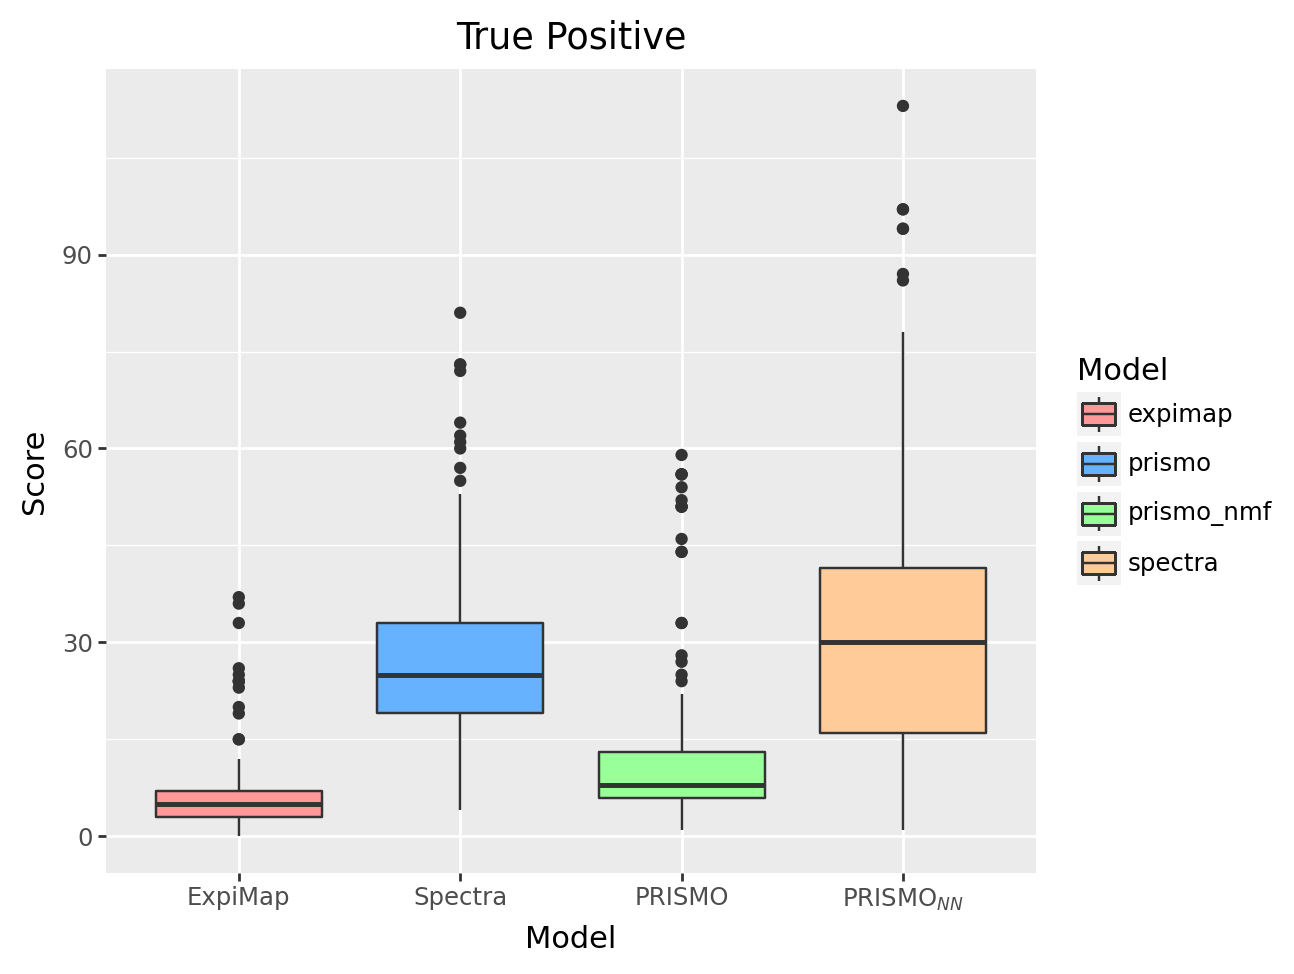

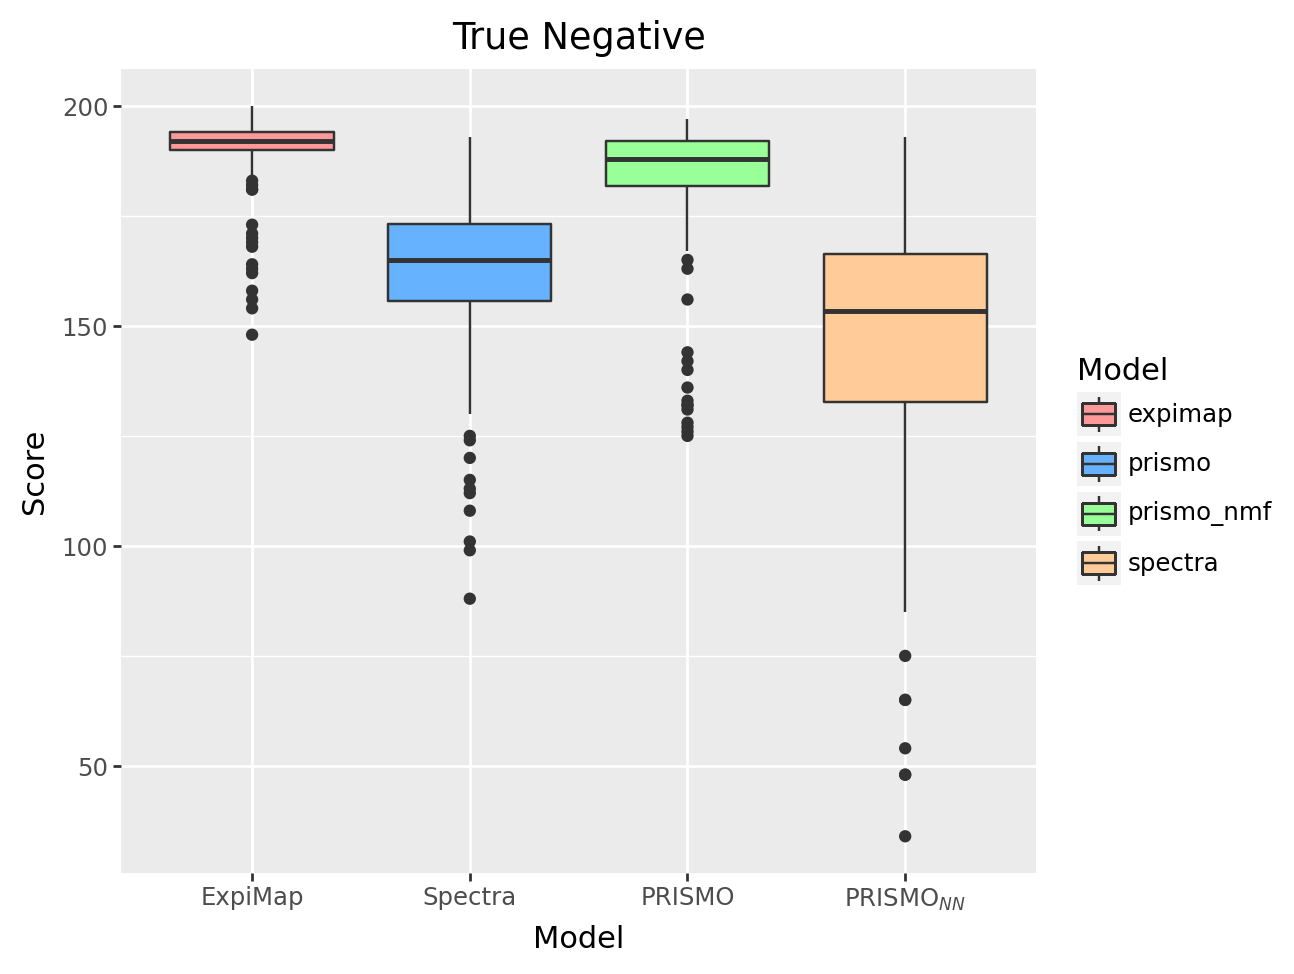

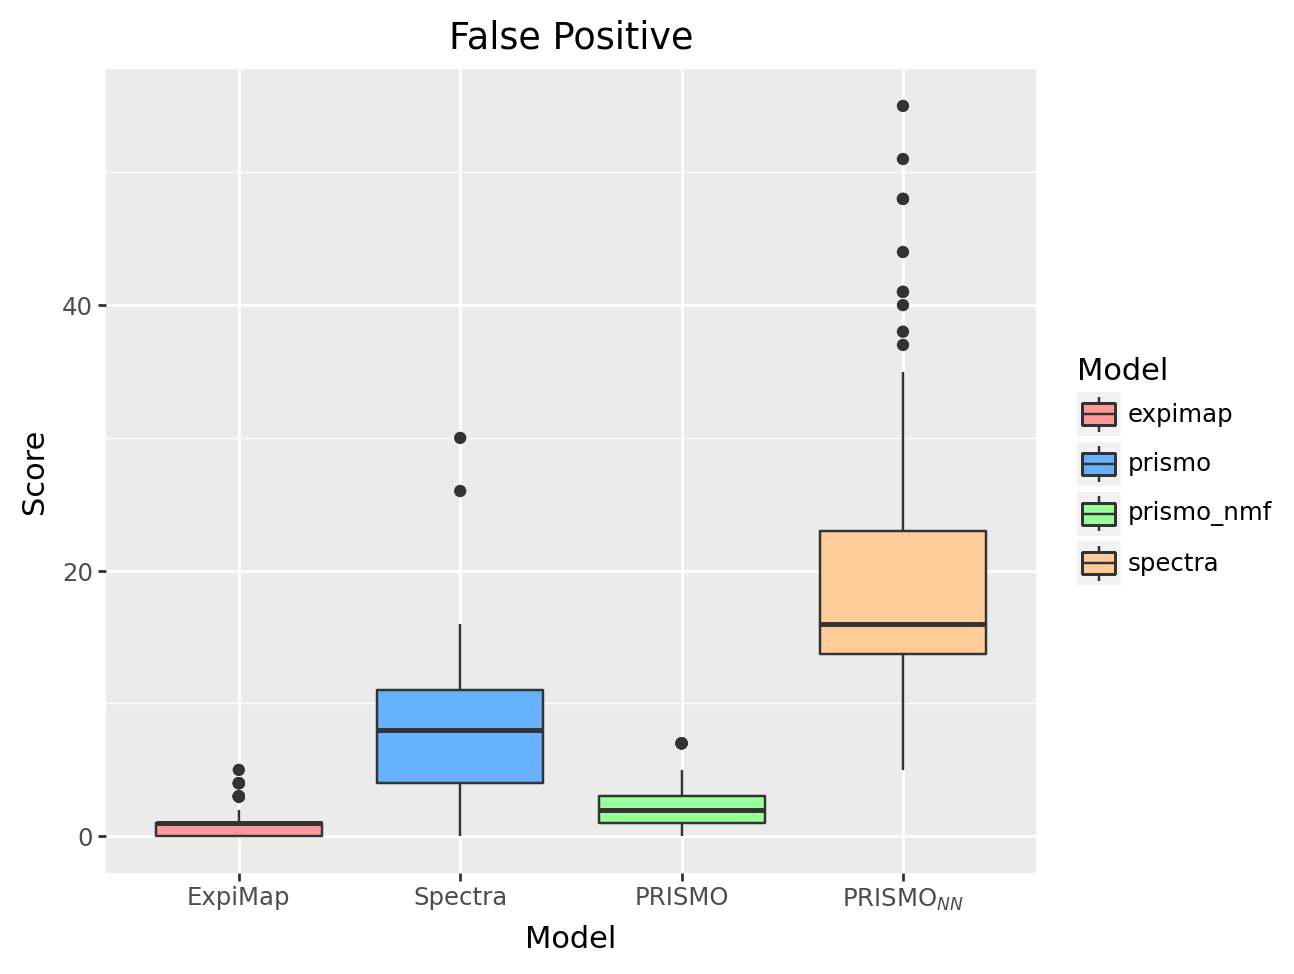

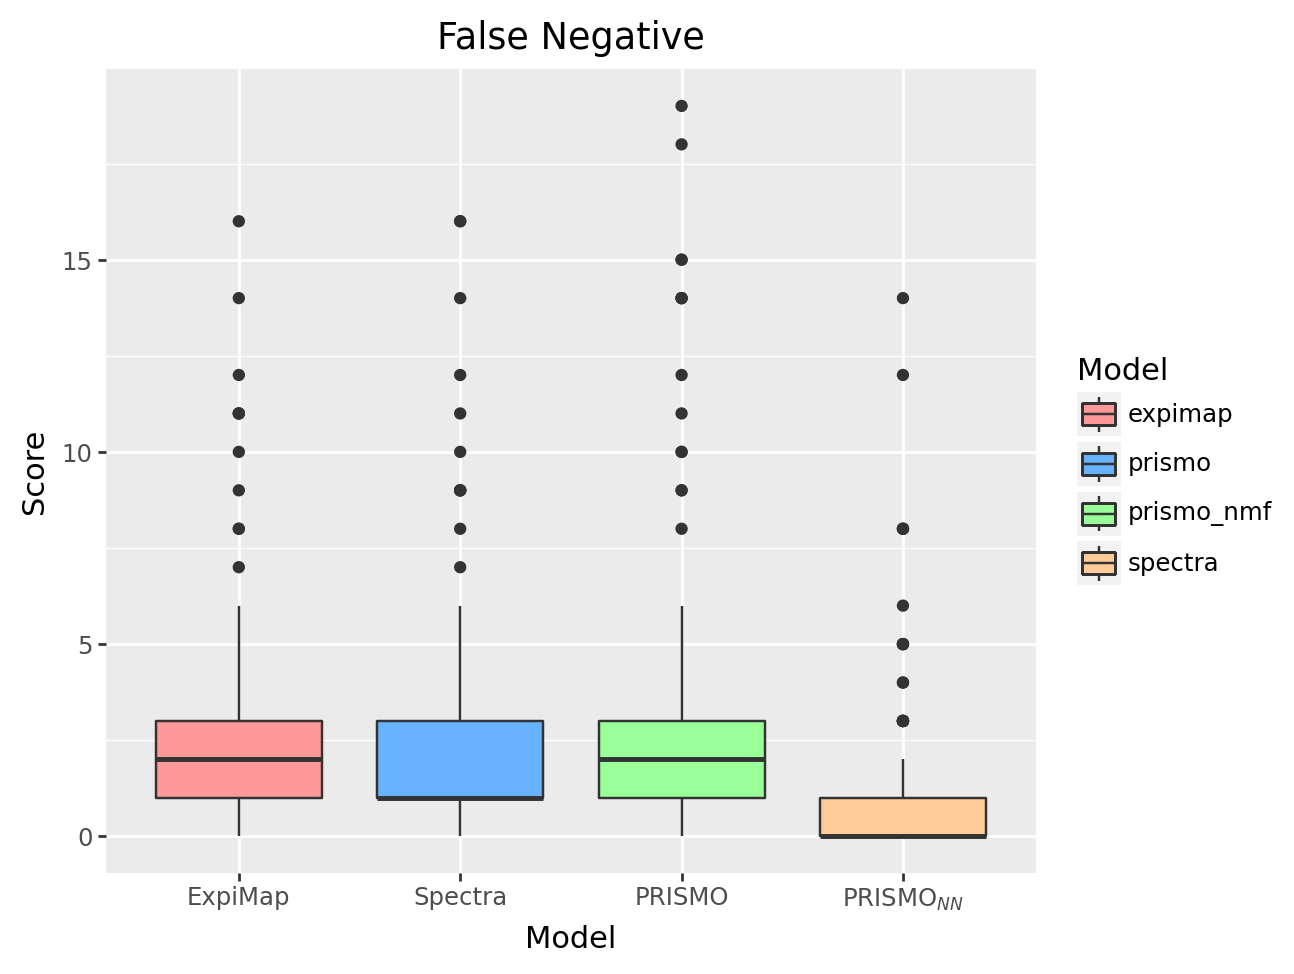

index       Model  Score
0        0     expimap      1
1        1     expimap      3
2        2     expimap      6
3        3     expimap      4
4        4     expimap      1
..     ...         ...    ...
475    115  prismo_nmf      1
476    116  prismo_nmf      0
477    117  prismo_nmf      1
478    118  prismo_nmf      0
479    119  prismo_nmf      4

[480 rows x 3 columns]

In [23]:
plot_scores(
    {
        "True Positive": tp_df,
        "True Negative": tn_df,
        "False Positive": fp_df,
        "False Negative": fn_df,
    },
    model_names,
    model_labels,
)
# plot_scores(
#     {"False Positive": fp_df, "False Negative": fn_df}, model_names, model_labels
# )

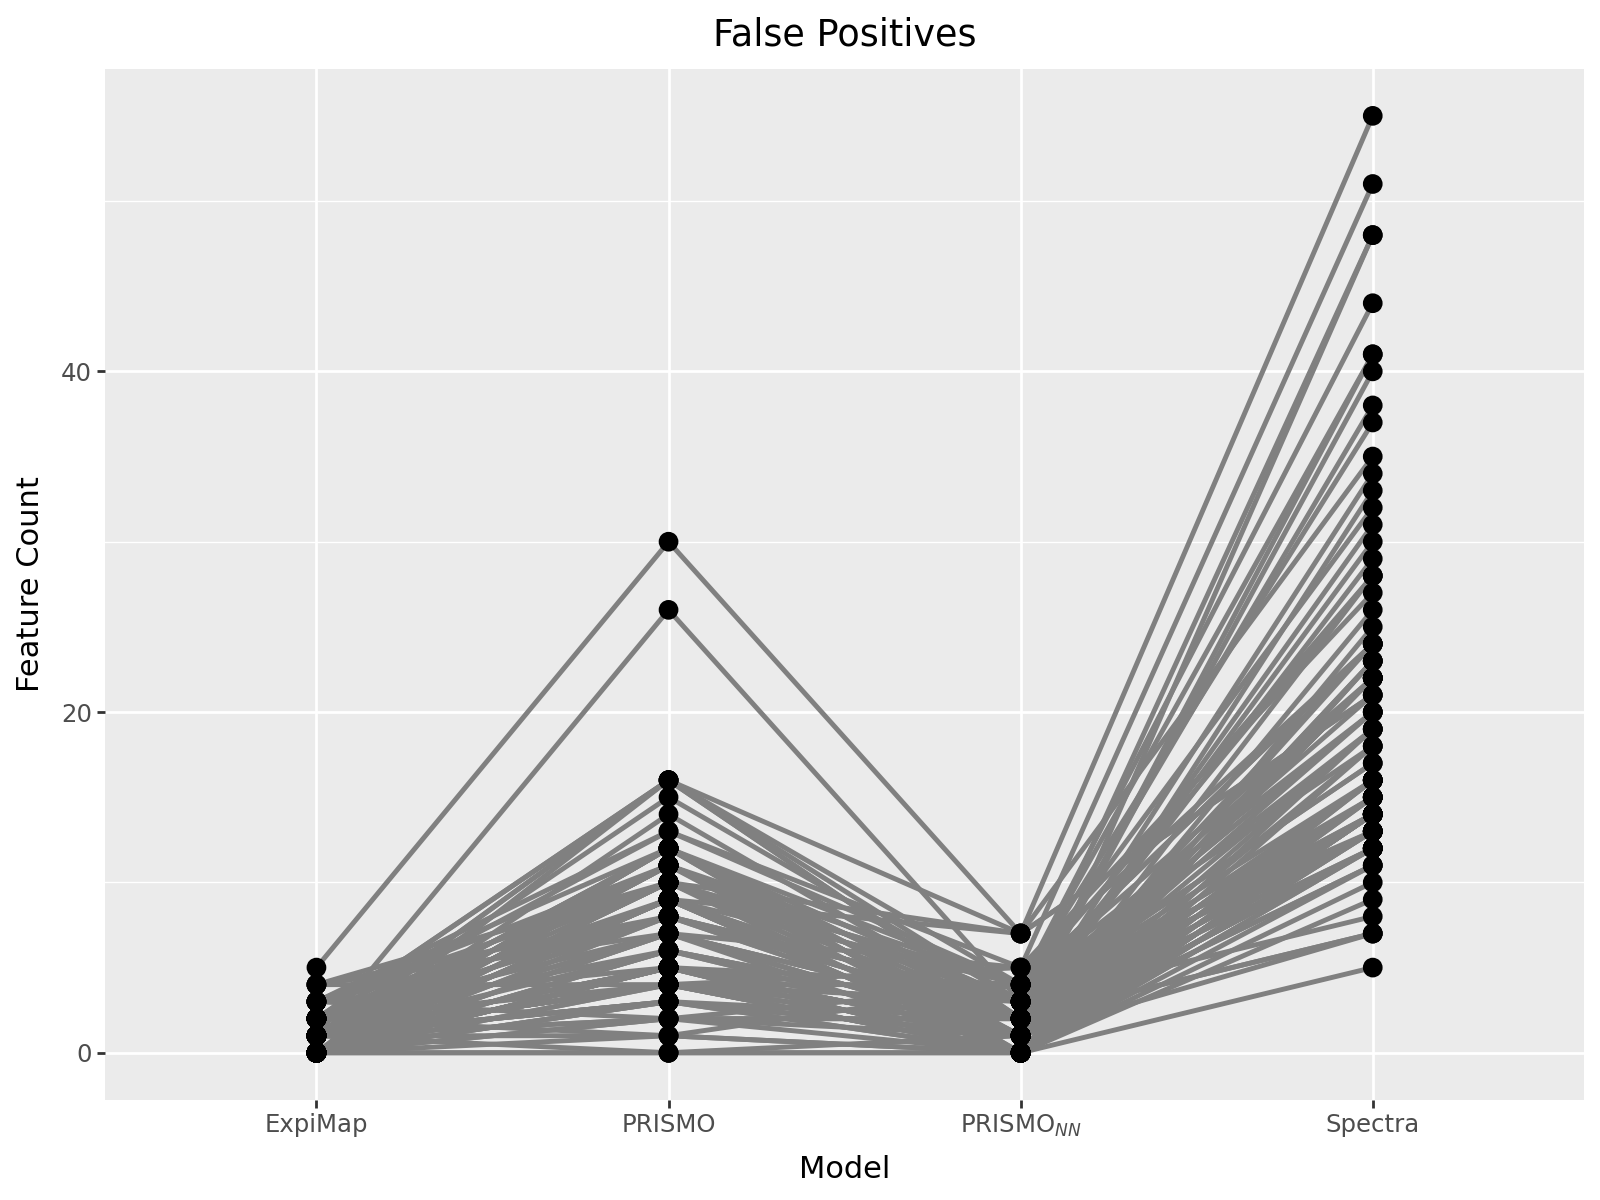

In [ ]:
model_cols = model_names
point_df = fp_df[model_cols].copy()
model_cols = model_labels

point_df.columns = model_cols
point_df["factor"] = point_df.index.copy()
point_df = pd.melt(
    point_df,
    id_vars=["factor"],
    value_vars=model_cols,
    var_name="Model",
    value_name="Feature Count",
)

(
    ggplot(point_df, aes(x="Model", y="Feature Count", group="factor"))
    + geom_line(alpha=1.0, color="gray", size=1)
    + geom_point(alpha=1.0, color="black", size=3)
    + ggtitle("False Positives")
    + theme(figure_size=(8, 6))
)

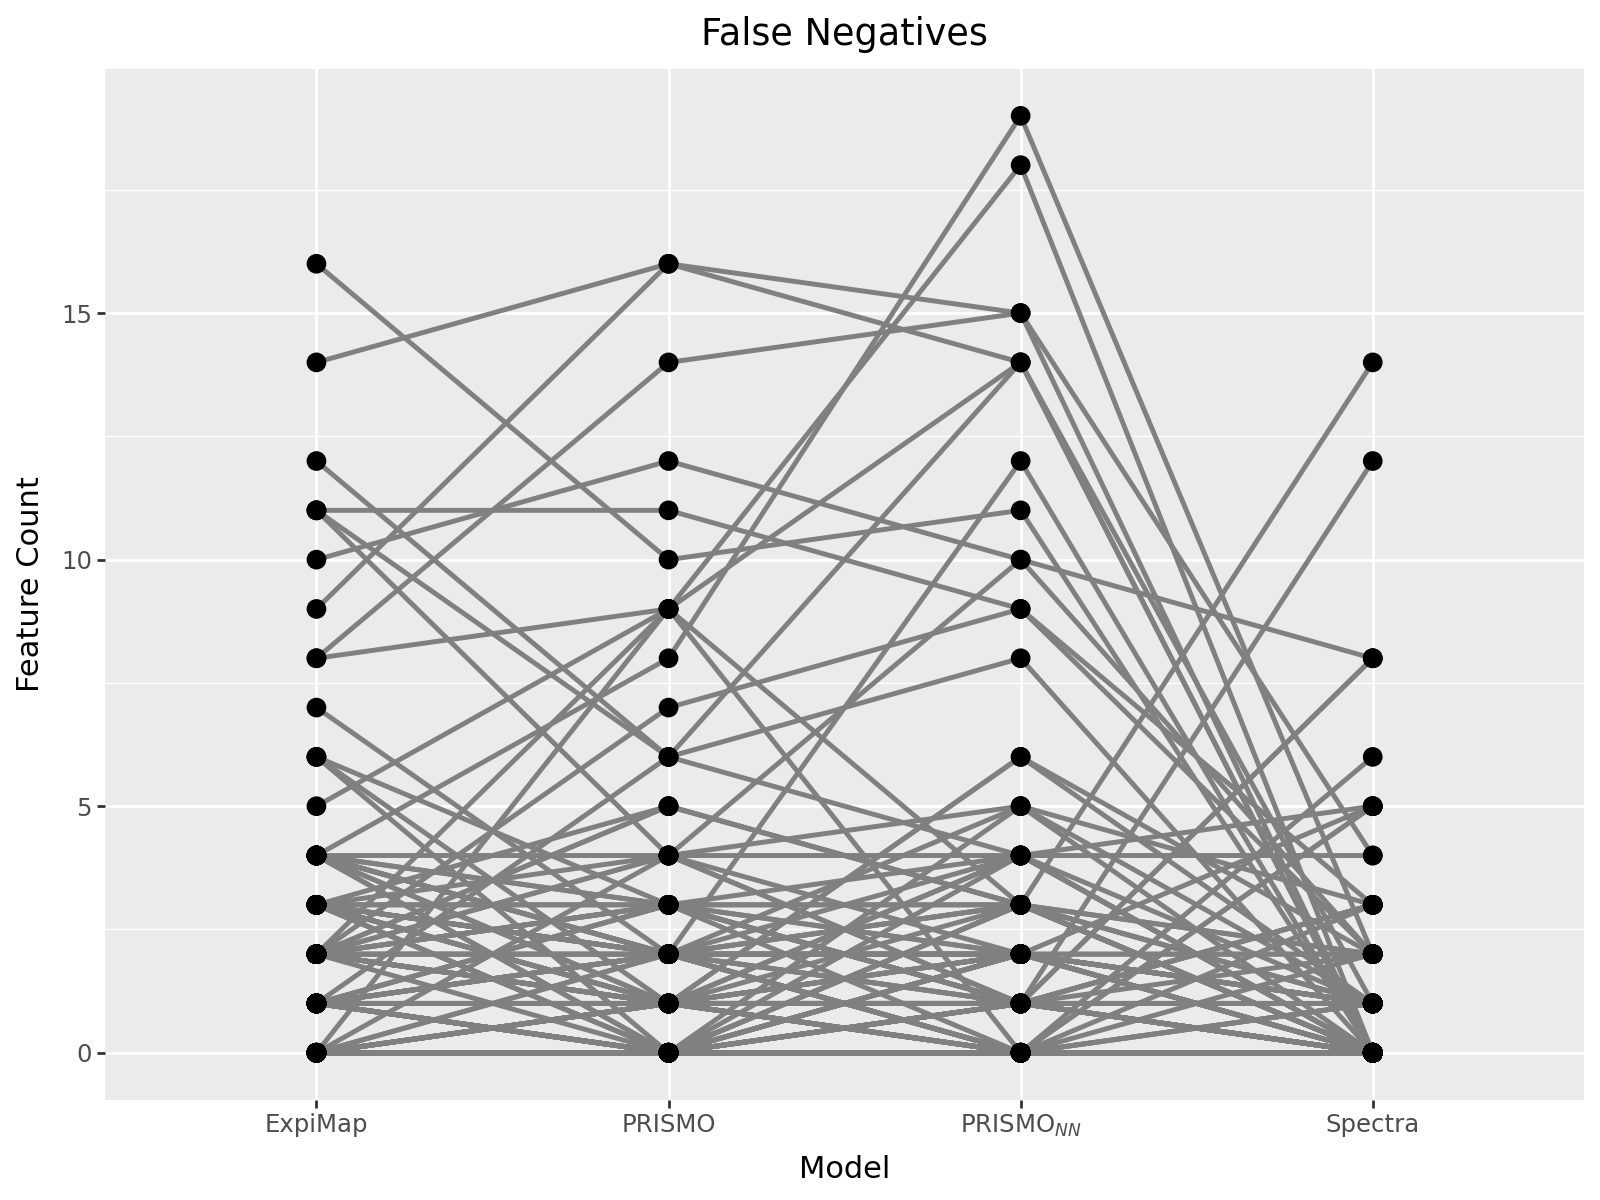

In [ ]:
model_cols = model_names
point_df = fn_df[model_cols].copy()
model_cols = model_labels

point_df.columns = model_cols
point_df["factor"] = point_df.index.copy()
point_df = pd.melt(
    point_df,
    id_vars=["factor"],
    value_vars=model_cols,
    var_name="Model",
    value_name="Feature Count",
)

(
    ggplot(point_df, aes(x="Model", y="Feature Count", group="factor"))
    + geom_line(alpha=1.0, color="gray", size=1)
    + geom_point(alpha=1.0, color="black", size=3)
    + ggtitle("False Negatives")
    + theme(figure_size=(8, 6))
)

In [ ]:
for top in [50, 100, 200, 500]:
    top_overlap_dict = {}
    for k in range(true_mask.shape[0]):
        d = None
        for mn, v in idx_df.items():
            if "nmf" in mn:
                continue
            s = set(v[k, :top])
            if d is None:
                d = s
            else:
                d &= s
        top_overlap_dict[terms[k]] = adata.var_names[sorted(d)]
    print("DONE")

DONE
DONE
DONE
DONE


In [27]:
[(i, t) for i, t in enumerate(terms) if "INTERFERON" in t]

[(26, 'REACTOME_DDX58_IFIH1_MEDIATED_INDUCTION_OF_INTERFERON_ALPHA_BETA'),
 (49, 'REACTOME_INTERFERON_ALPHA_BETA_SIGNALING'),
 (50, 'REACTOME_INTERFERON_GAMMA_SIGNALING'),
 (51, 'REACTOME_INTERFERON_SIGNALING')]

In [28]:
[(i, t) for i, t in enumerate(terms) if "B_CELL" in t]

[(34, 'REACTOME_DOWNSTREAM_SIGNALING_EVENTS_OF_B_CELL_RECEPTOR_BCR'),
 (99, 'REACTOME_SIGNALING_BY_THE_B_CELL_RECEPTOR_BCR')]

In [29]:
pd.DataFrame(per_factor_aupr).loc[[49, 50, 51], :]

expimap   spectra    prismo  prismo_nmf
49  0.087088  0.862462  0.614794    0.516834
50  0.006135  0.895260  0.388039    0.558219
51  0.178090  0.581922  0.572776    0.454188

In [30]:
pd.DataFrame(per_factor_aupr).loc[[99], :]

expimap   spectra    prismo  prismo_nmf
99  0.052107  0.205987  0.385596    0.253978

In [31]:
[(i, t) for i, t in enumerate(model_dict[model_name].factor_names) if "INTERFERON" in t]

[(29, 'REACTOME_DDX58_IFIH1_MEDIATED_INDUCTION_OF_INTERFERON_ALPHA_BETA'),
 (52, 'REACTOME_INTERFERON_ALPHA_BETA_SIGNALING'),
 (53, 'REACTOME_INTERFERON_GAMMA_SIGNALING'),
 (54, 'REACTOME_INTERFERON_SIGNALING')]

In [32]:
[(i, t) for i, t in enumerate(model_dict[model_name].factor_names) if "B_CELL" in t]

[(37, 'REACTOME_DOWNSTREAM_SIGNALING_EVENTS_OF_B_CELL_RECEPTOR_BCR'),
 (102, 'REACTOME_SIGNALING_BY_THE_B_CELL_RECEPTOR_BCR')]

ROC: 0.487725749841416


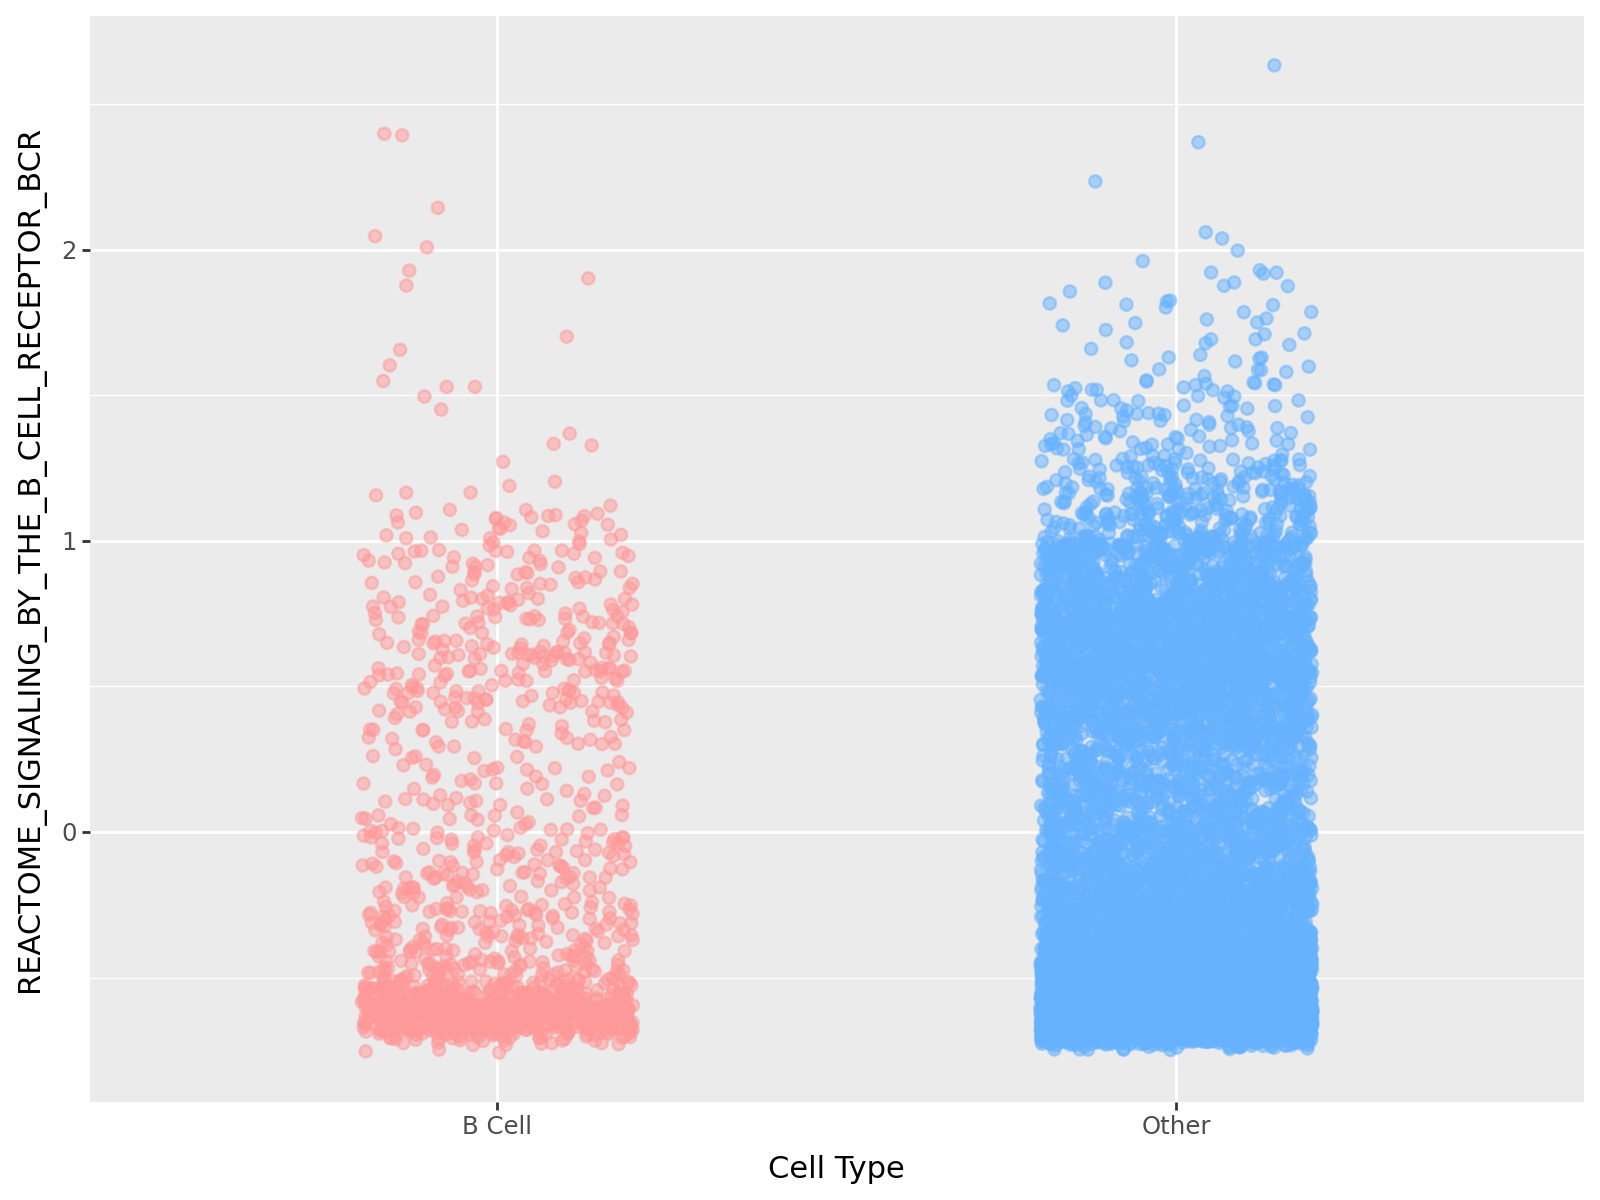

In [ ]:
model_name = "prismo"
factor_name = "REACTOME_SIGNALING_BY_THE_B_CELL_RECEPTOR_BCR"
adata.obs[factor_name] = (
    model_dict[model_name].get_factors()["group_1"].loc[:, factor_name]
)
adata.obs
adata.obs["Cell Type"] = "Other"
adata.obs.loc[adata.obs["cell_type"] == "B", "Cell Type"] = "B Cell"
print("ROC:", roc_auc_score(adata.obs["Cell Type"], adata.obs[factor_name]))

(
    ggplot(adata.obs, aes(x="Cell Type", y=factor_name, color="Cell Type"))
    + geom_jitter(alpha=0.5, size=2, width=0.2, height=0)
    + scale_color_manual(values={"B Cell": colors_disc[0], "Other": colors_disc[1]})
    + scale_x_discrete(limits=["B Cell", "Other"])
    + theme(figure_size=(8, 6), legend_position="none")
)

ROC: 0.002669018344731864


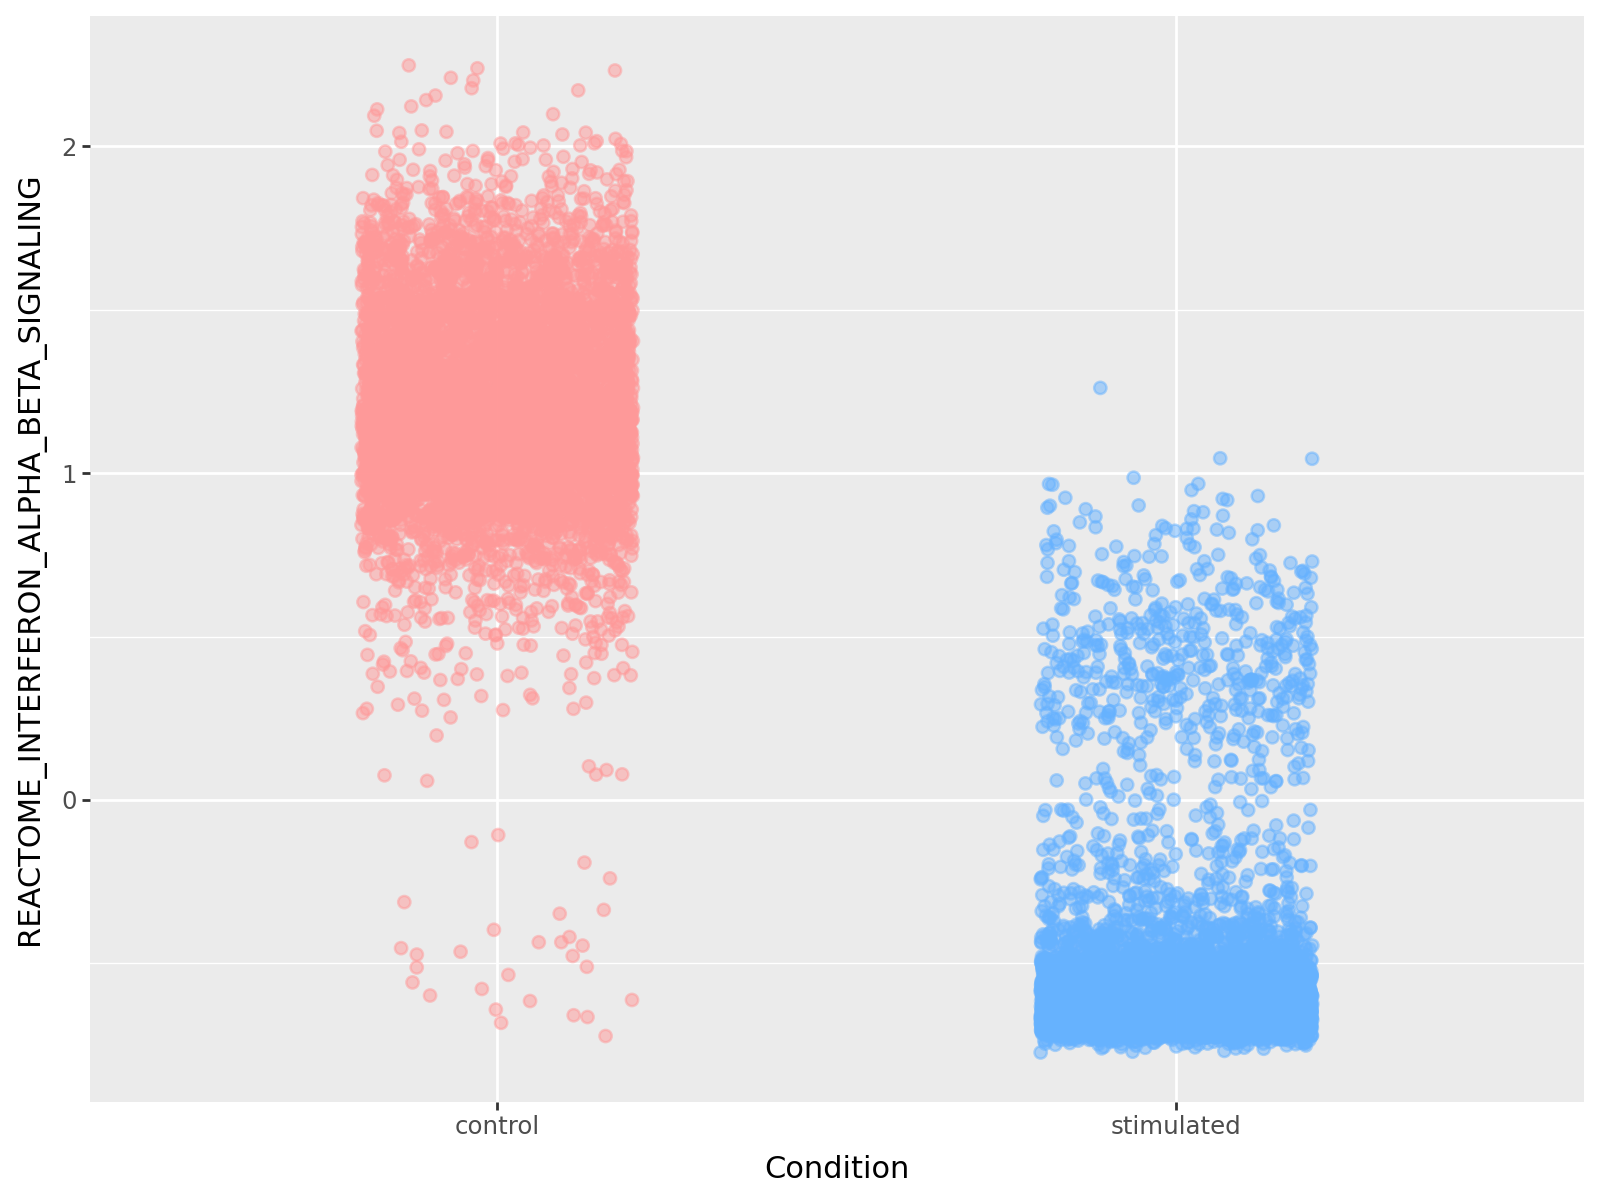

In [ ]:
model_name = "prismo"
factor_name = "REACTOME_INTERFERON_ALPHA_BETA_SIGNALING"
adata.obs[factor_name] = (
    model_dict[model_name].get_factors()["group_1"].loc[:, factor_name]
)
print("ROC:", roc_auc_score(adata.obs["condition"], adata.obs[factor_name]))

(
    ggplot(adata.obs, aes(x="condition", y=factor_name, color="condition"))
    + geom_jitter(alpha=0.5, size=2, width=0.2, height=0)
    + scale_color_manual(
        values={"control": colors_disc[0], "stimulated": colors_disc[1]}
    )
    + theme(
        figure_size=(8, 6),
        legend_position="none",
    )
    + labs(x="Condition", y=factor_name)
)

In [35]:
prismo_model = model_dict["prismo"]

In [36]:
adata_latent = prismo_model.get_factors("anndata")["group_1"].copy()
adata_latent.obs = adata.obs.copy()
obs_names = adata_latent.obs_names.to_numpy()
# np.random.shuffle(obs_names)
adata_latent = adata_latent[obs_names, :].copy()
adata_latent

AnnData object with n_obs × n_vars = 13576 × 123
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'stim', 'seurat_annotations', 'integrated_snn_res.0.5', 'seurat_clusters', 'condition', 'cell_type', 'REACTOME_SIGNALING_BY_THE_B_CELL_RECEPTOR_BCR', 'Cell Type', 'REACTOME_INTERFERON_ALPHA_BETA_SIGNALING'

### UMAP plots

In [38]:
sc.pp.neighbors(adata_latent, use_rep="X")
sc.tl.leiden(adata_latent)
sc.tl.umap(adata_latent)

/tmp/ipykernel_75941/234158693.py:2: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.


In [117]:
df_plot = pd.DataFrame(
    {
        "x": adata_latent.obsm["X_umap"][:, 0],
        "y": adata_latent.obsm["X_umap"][:, 1],
        "cell type": adata_latent.obs["cell_type"],
        "condition": adata_latent.obs["condition"],
    }
)

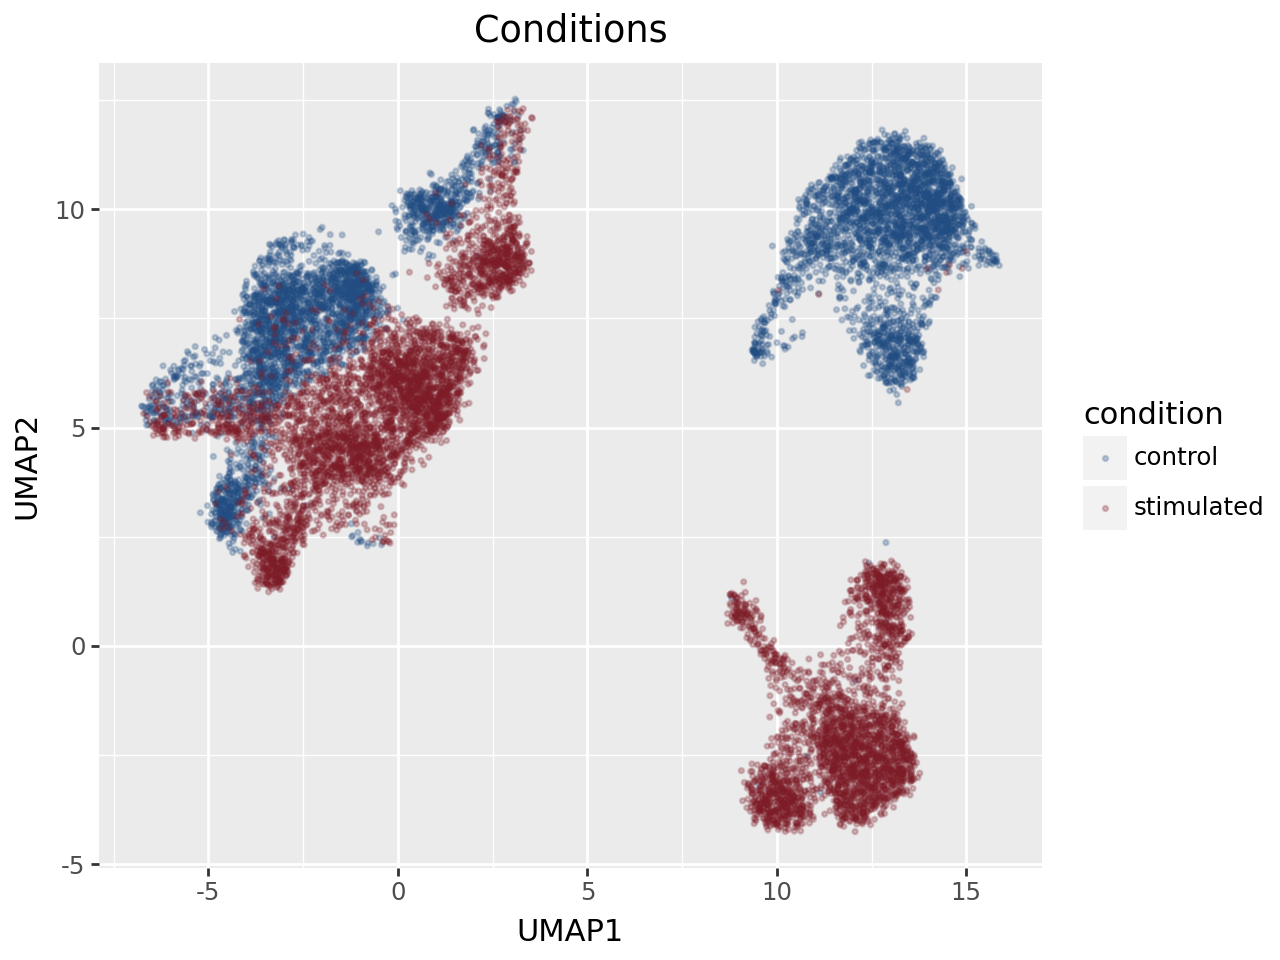

In [121]:
from plotnine import ggplot, aes, geom_point, scale_color_brewer, theme_minimal, labs
(
    ggplot(df_plot, aes(x="x", y="y", color="condition"))
    + geom_point(size=0.5, alpha=0.25)
    + labs(title="Conditions", x="UMAP1", y="UMAP2")
    + scale_color_manual(values=colors_div)
)

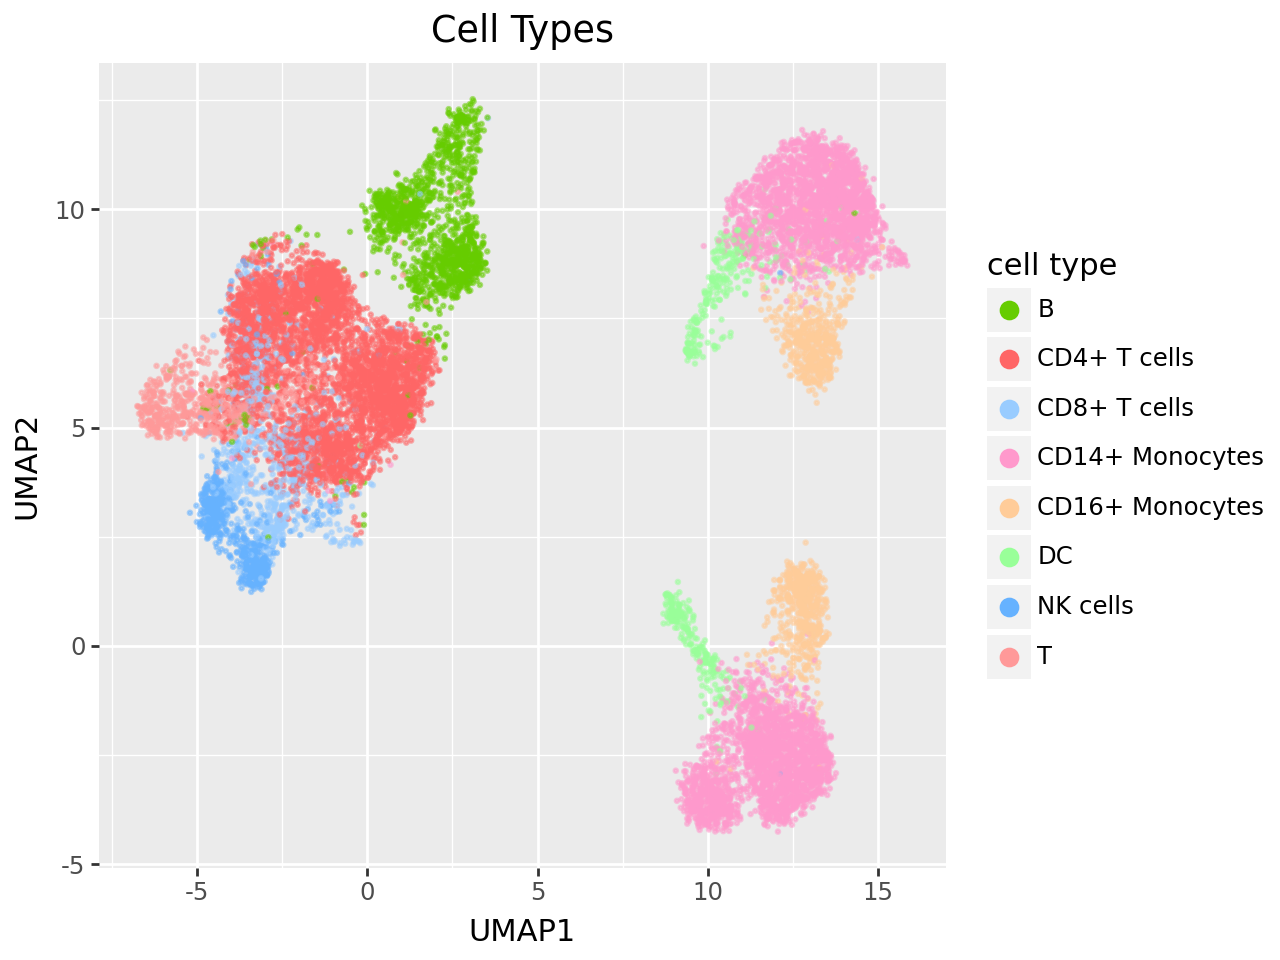

In [128]:
(
    ggplot(df_plot, aes(x="x", y="y", color="cell type"))
    + geom_point(size=0.33, alpha=0.5)
    + labs(title="Cell Types", x="UMAP1", y="UMAP2")
    + scale_color_manual(values=list(reversed(colors_disc)))
    + guides(color=guide_legend(override_aes={'size': 3, 'alpha': 1})))

sc.pl.umap(adata_latent, color=["condition", "cell_type"])

In [40]:
sc.tl.rank_genes_groups(adata_latent, groupby="condition")

/data/m015k/miniconda3/envs/prismo/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
/data/m015k/miniconda3/envs/prismo/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2


In [41]:
del adata_latent.obs["REACTOME_INTERFERON_ALPHA_BETA_SIGNALING"]
del adata_latent.obs["REACTOME_SIGNALING_BY_THE_B_CELL_RECEPTOR_BCR"]

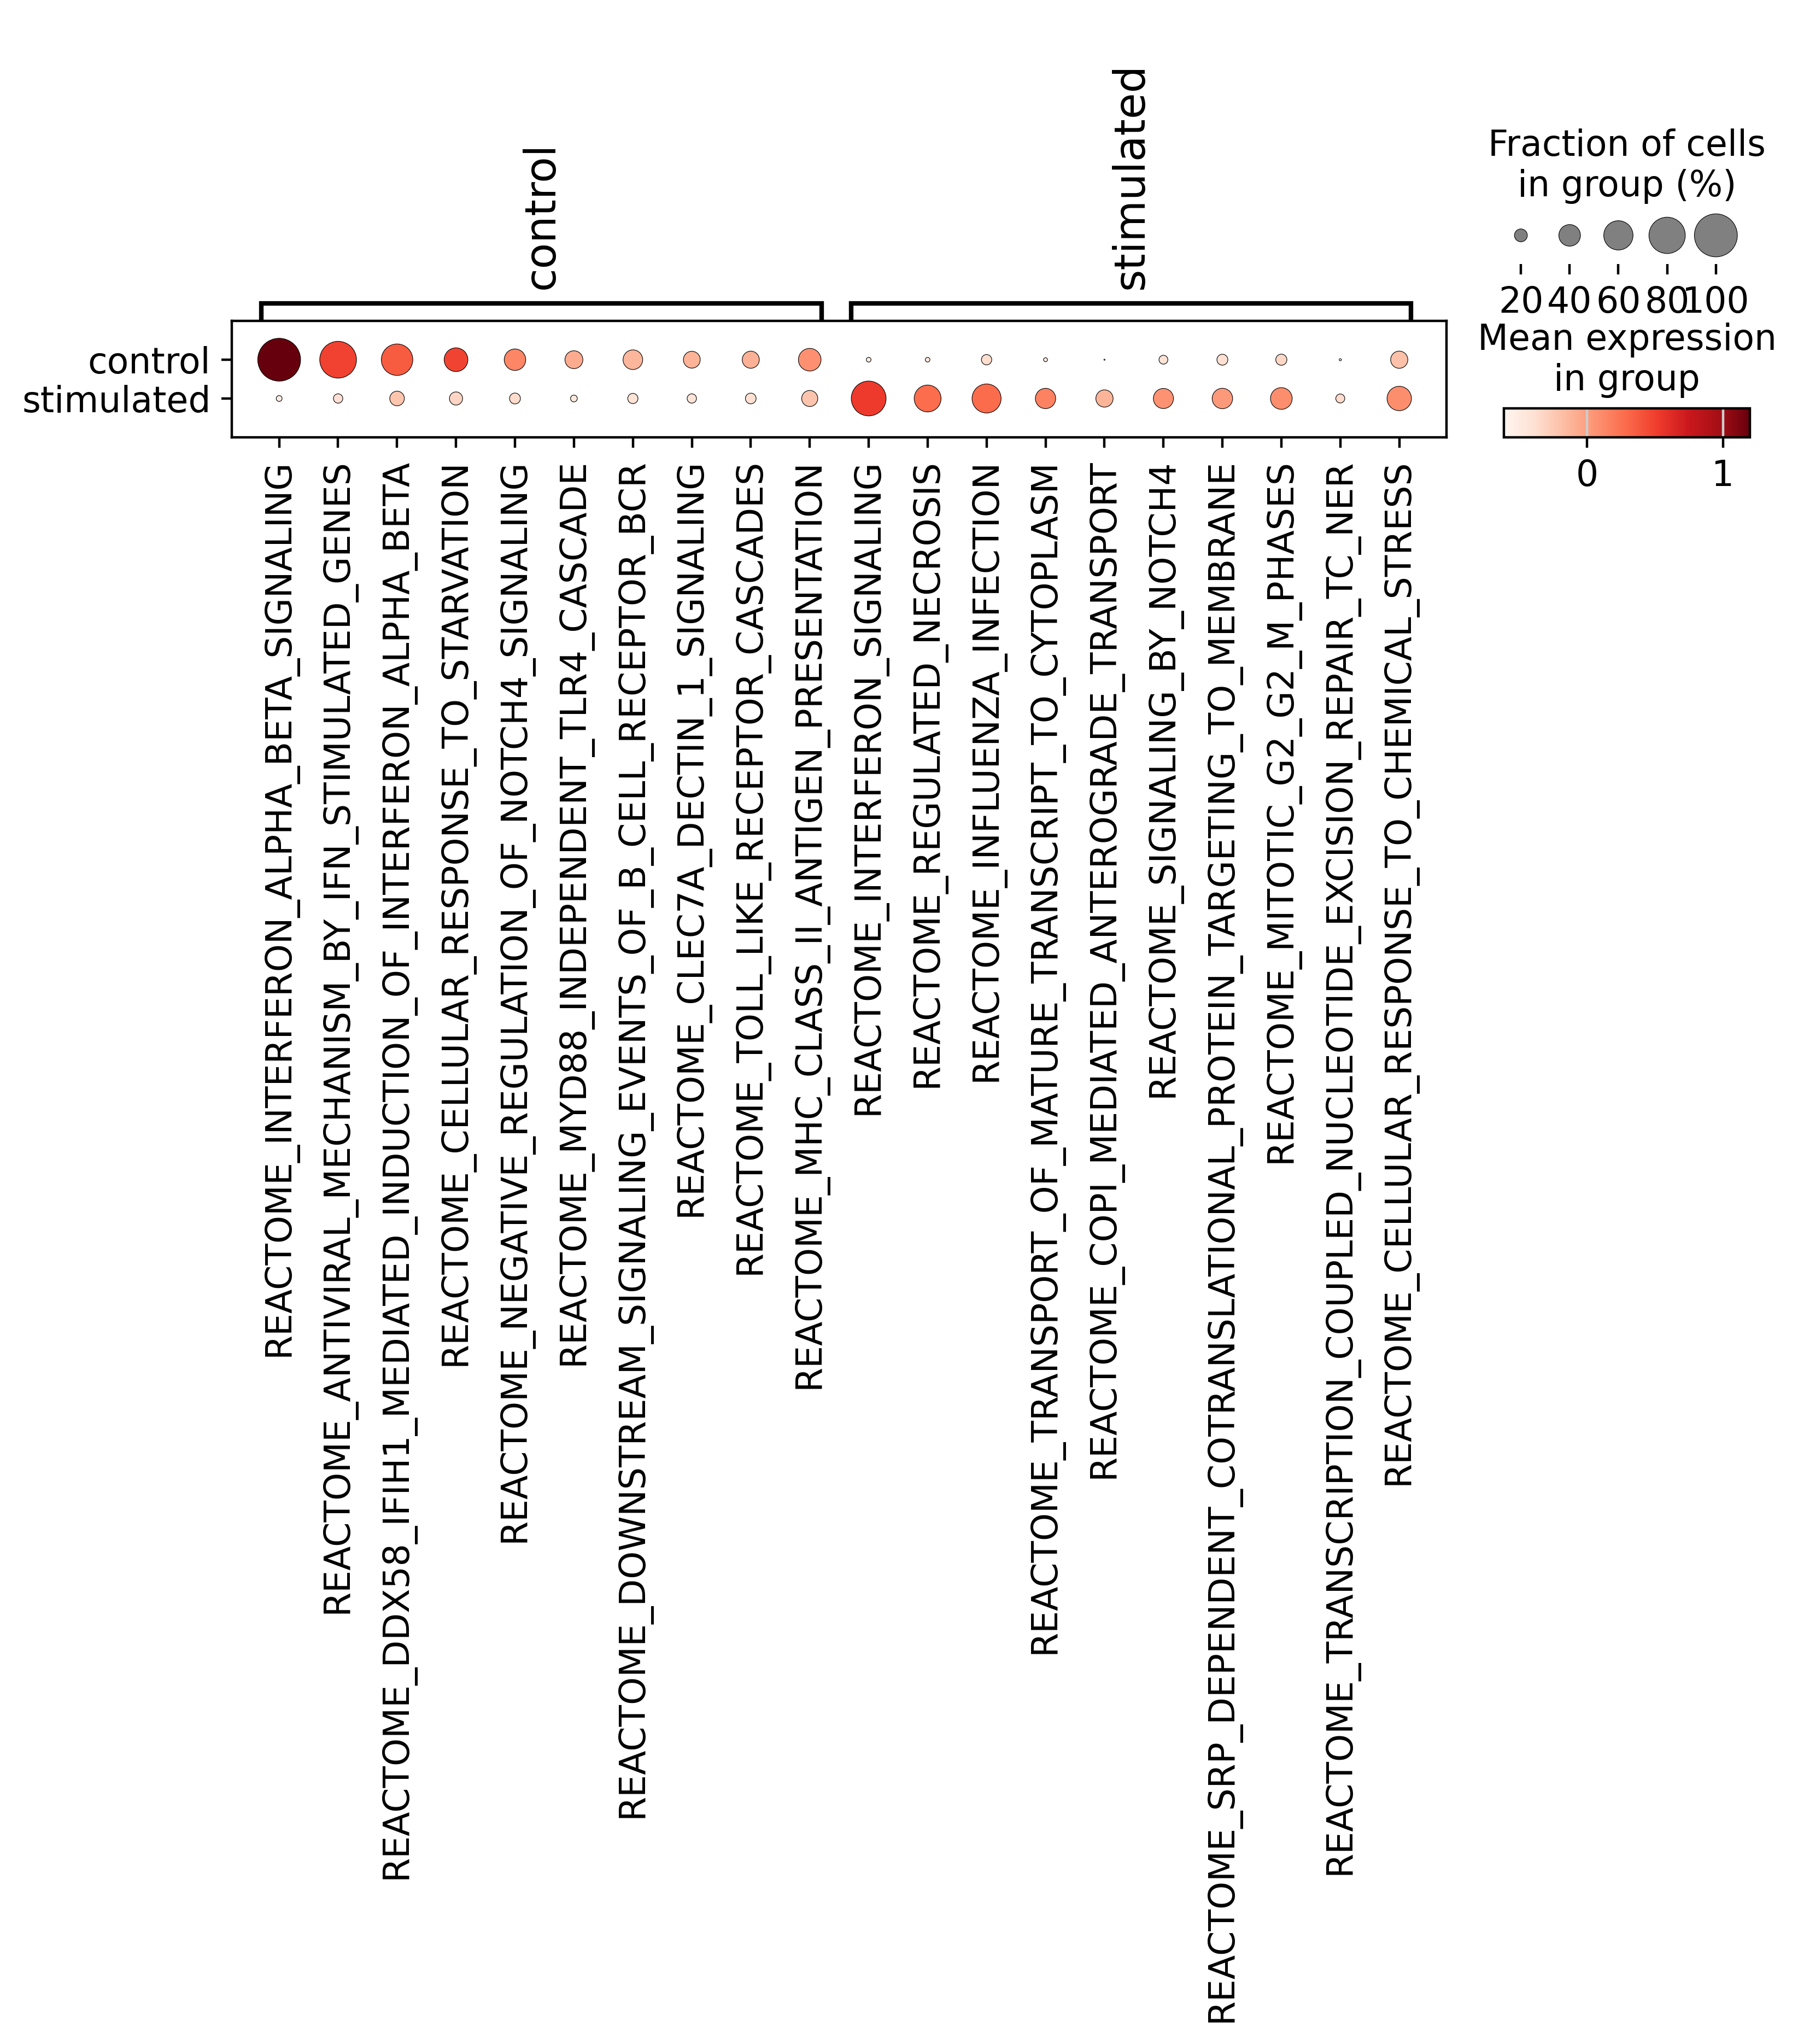

In [42]:
sc.pl.rank_genes_groups_dotplot(adata_latent)

In [43]:
[vn for vn in adata_latent.var_names if "INTERFER" in vn]

['REACTOME_DDX58_IFIH1_MEDIATED_INDUCTION_OF_INTERFERON_ALPHA_BETA',
 'REACTOME_INTERFERON_ALPHA_BETA_SIGNALING',
 'REACTOME_INTERFERON_GAMMA_SIGNALING',
 'REACTOME_INTERFERON_SIGNALING']

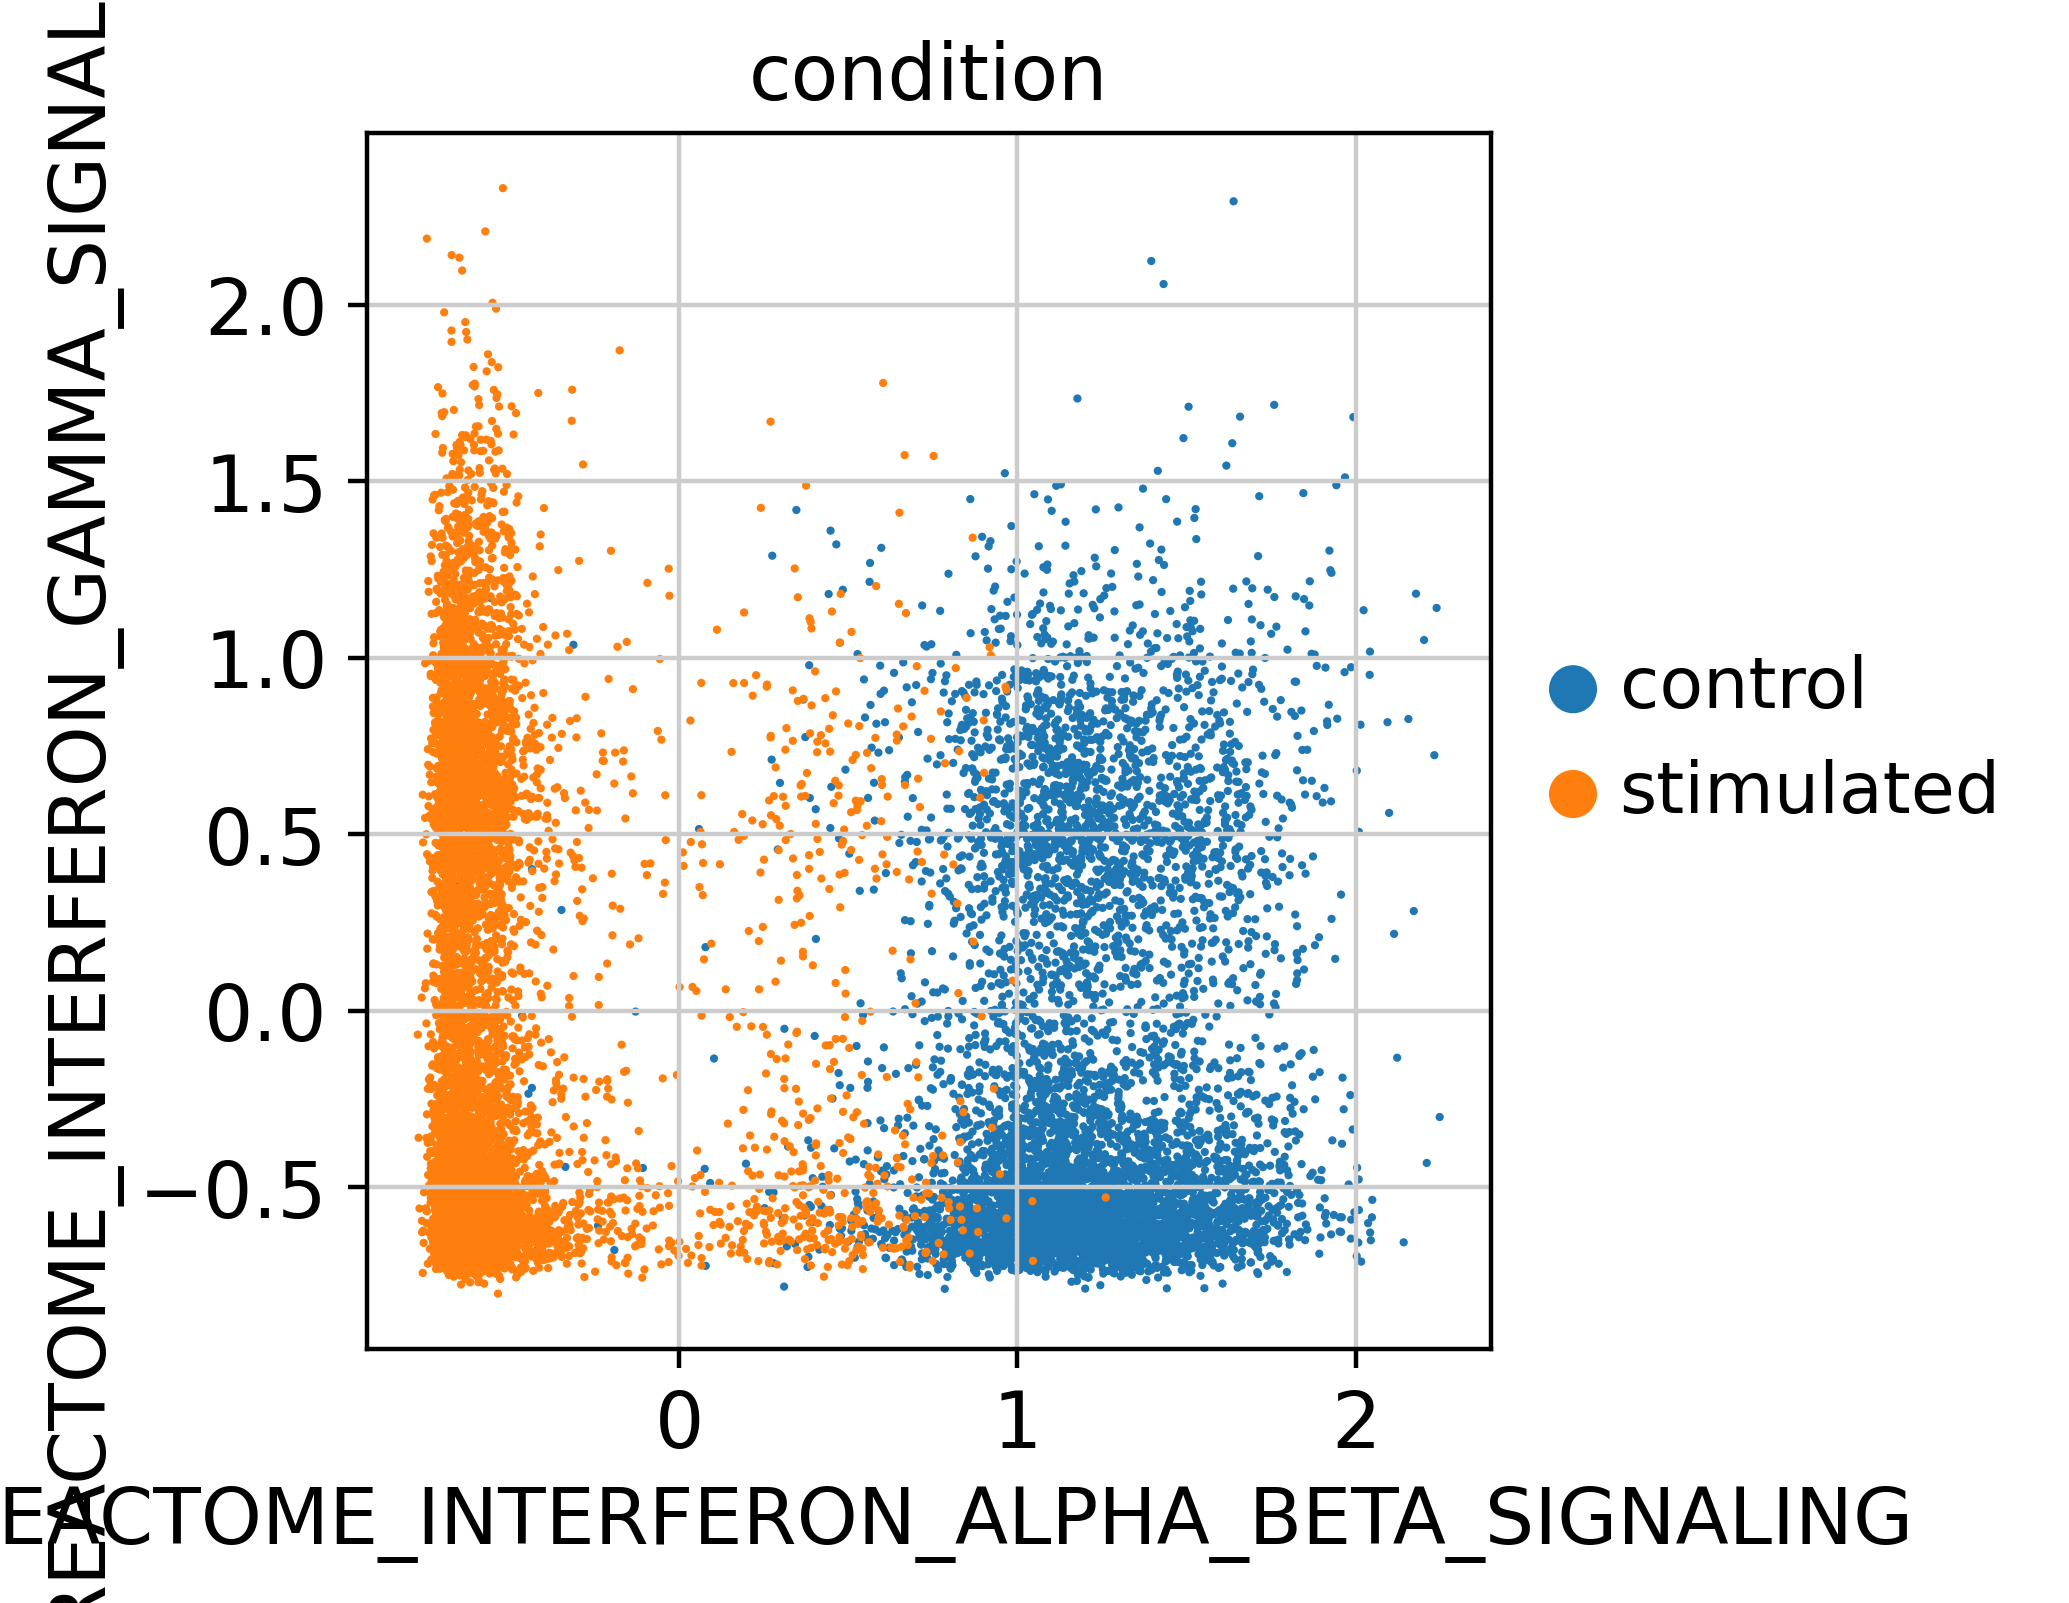

In [44]:
sc.pl.scatter(
    adata_latent,
    x="REACTOME_INTERFERON_ALPHA_BETA_SIGNALING",
    y="REACTOME_INTERFERON_GAMMA_SIGNALING",
    color="condition",
)

(<Figure size 1600x1600 with 1 Axes>,
 array([[<Axes: title={'center': 'REACTOME_INTERFERON_ALPHA_BETA_SIGNALING (view_0)'}, xlabel='Rank', ylabel='Loading'>]],
       dtype=object))

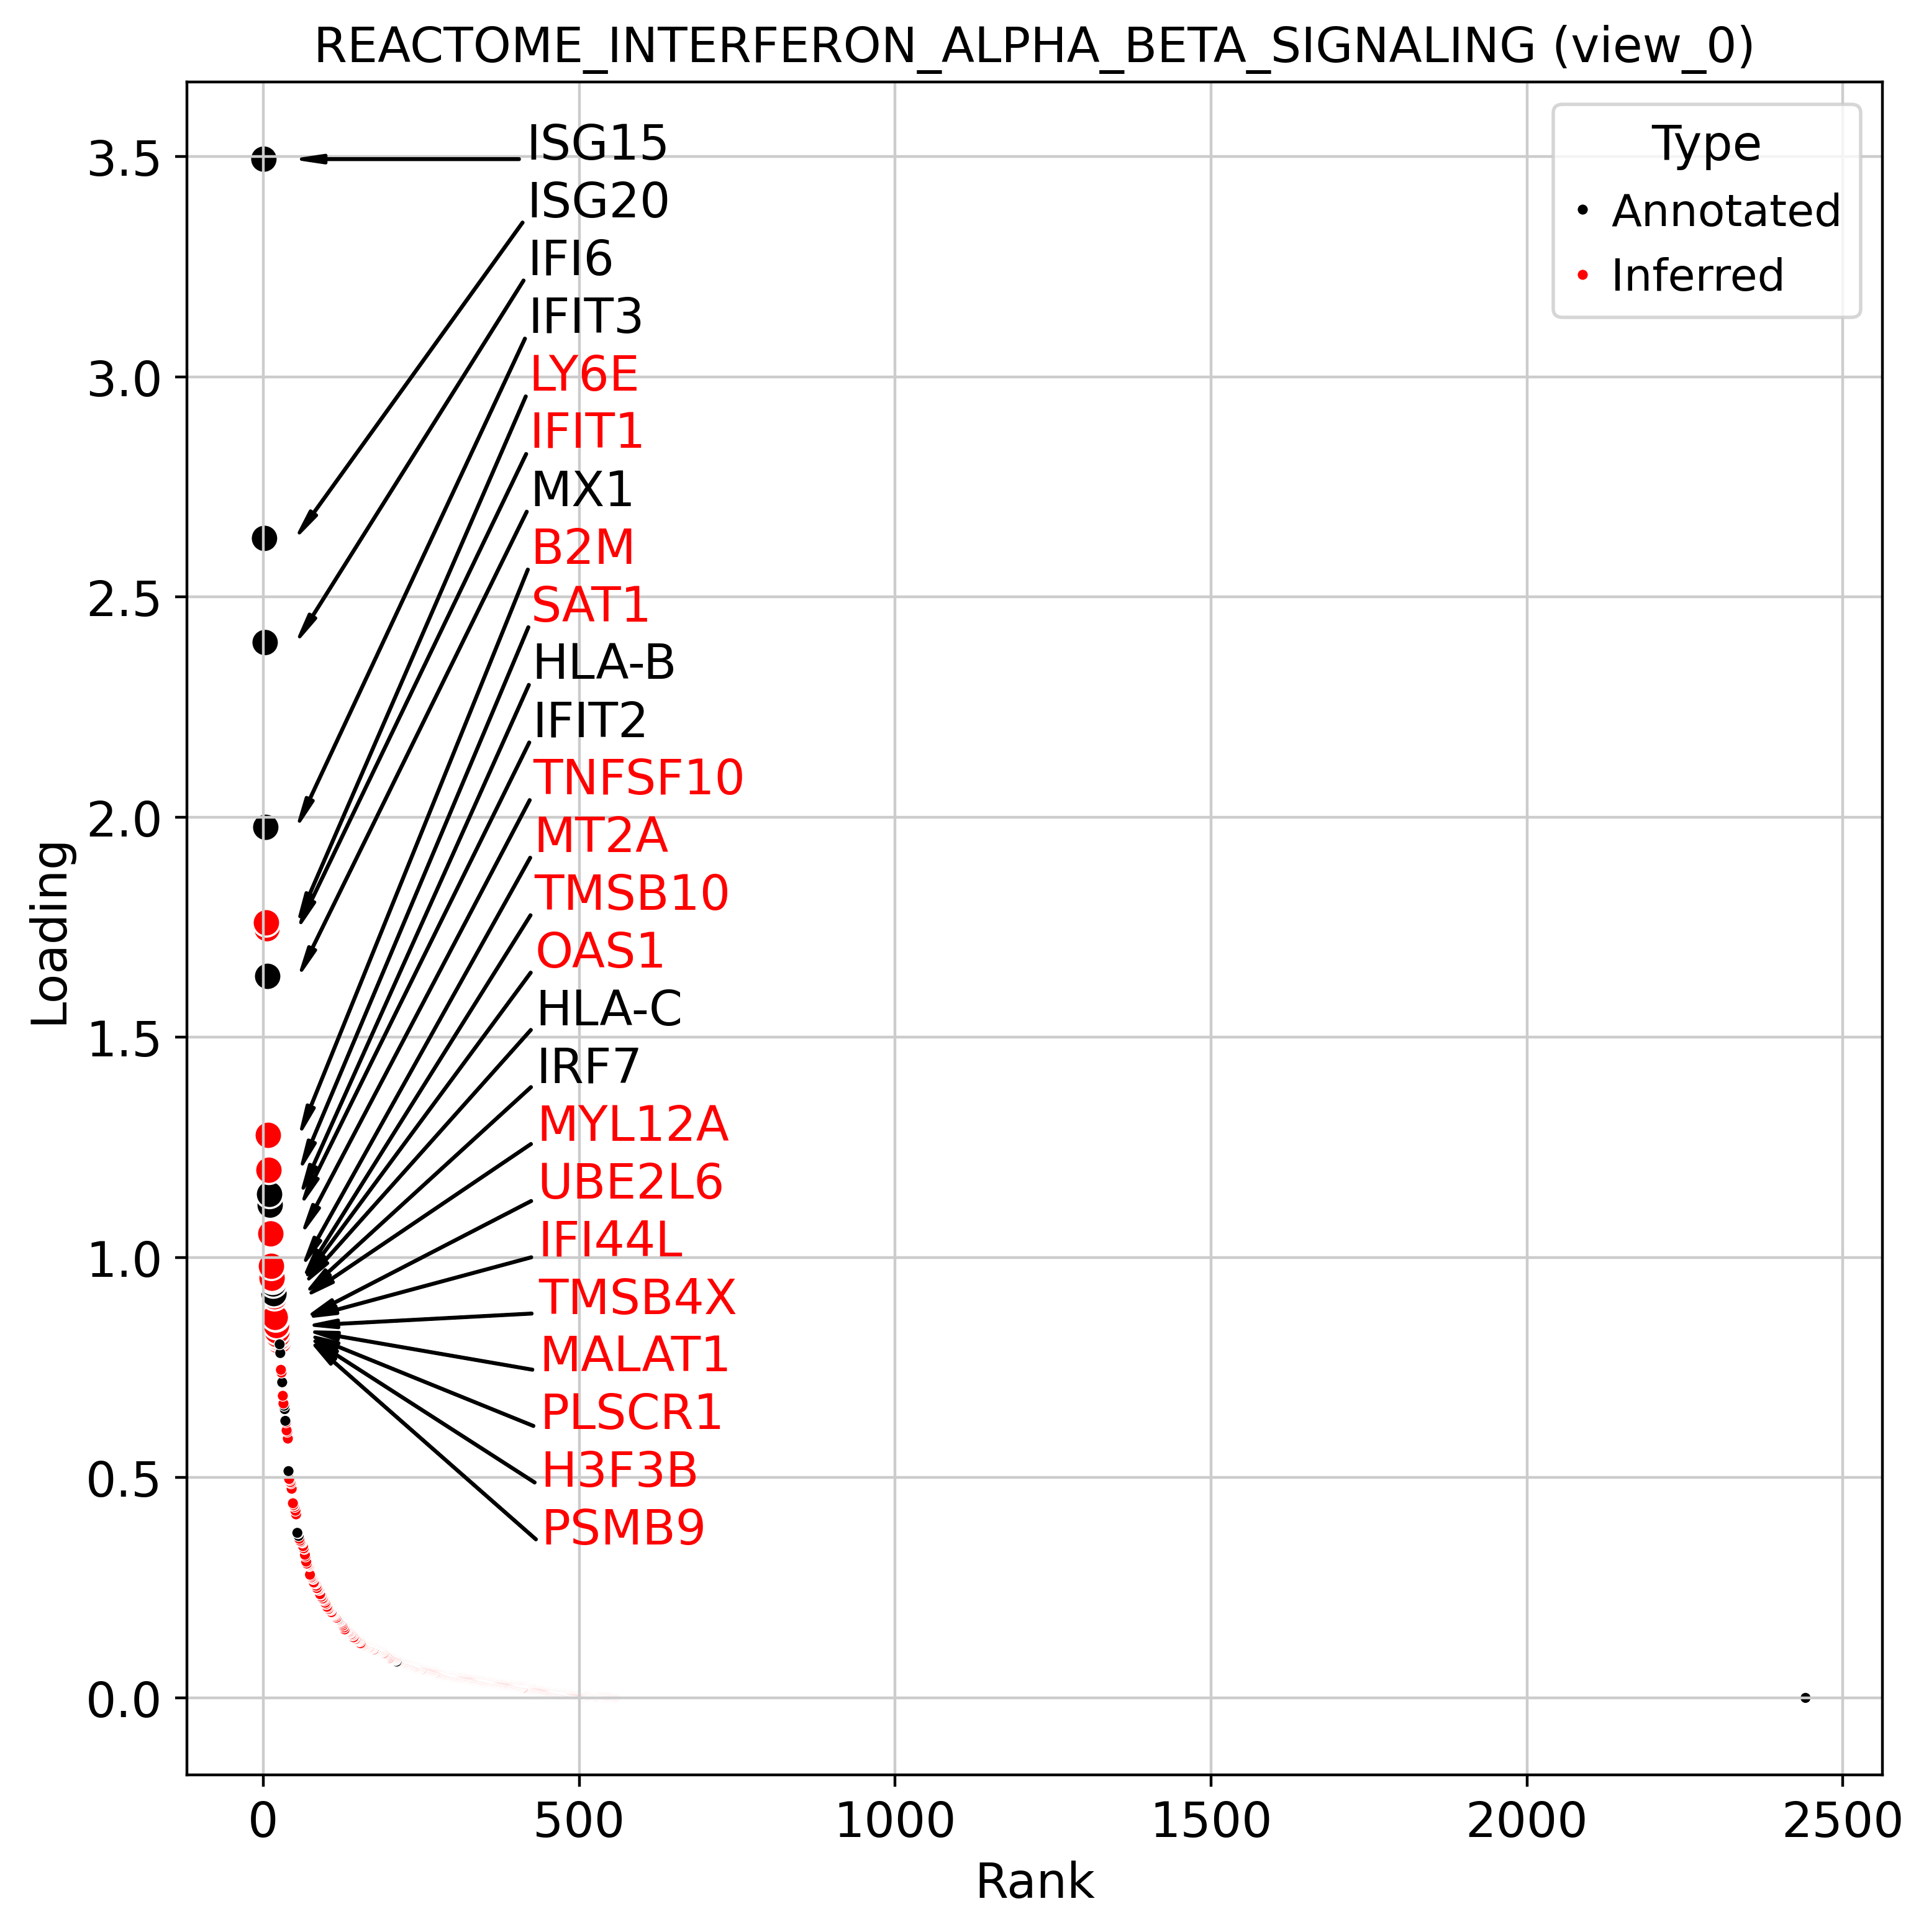

In [45]:
# plotting.plot_top_weights(model, "view_0", factor=4, nfeatures=10)
plotting.plot_top_weights(
    model,
    "REACTOME_INTERFERON_ALPHA_BETA_SIGNALING",
    view_idx="all",
    top=25,
    ranked=True,
)

(<Figure size 1600x1600 with 1 Axes>,
 array([[<Axes: title={'center': 'REACTOME_SIGNALING_BY_THE_B_CELL_RECEPTOR_BCR (view_0)'}, xlabel='Rank', ylabel='Loading'>]],
       dtype=object))

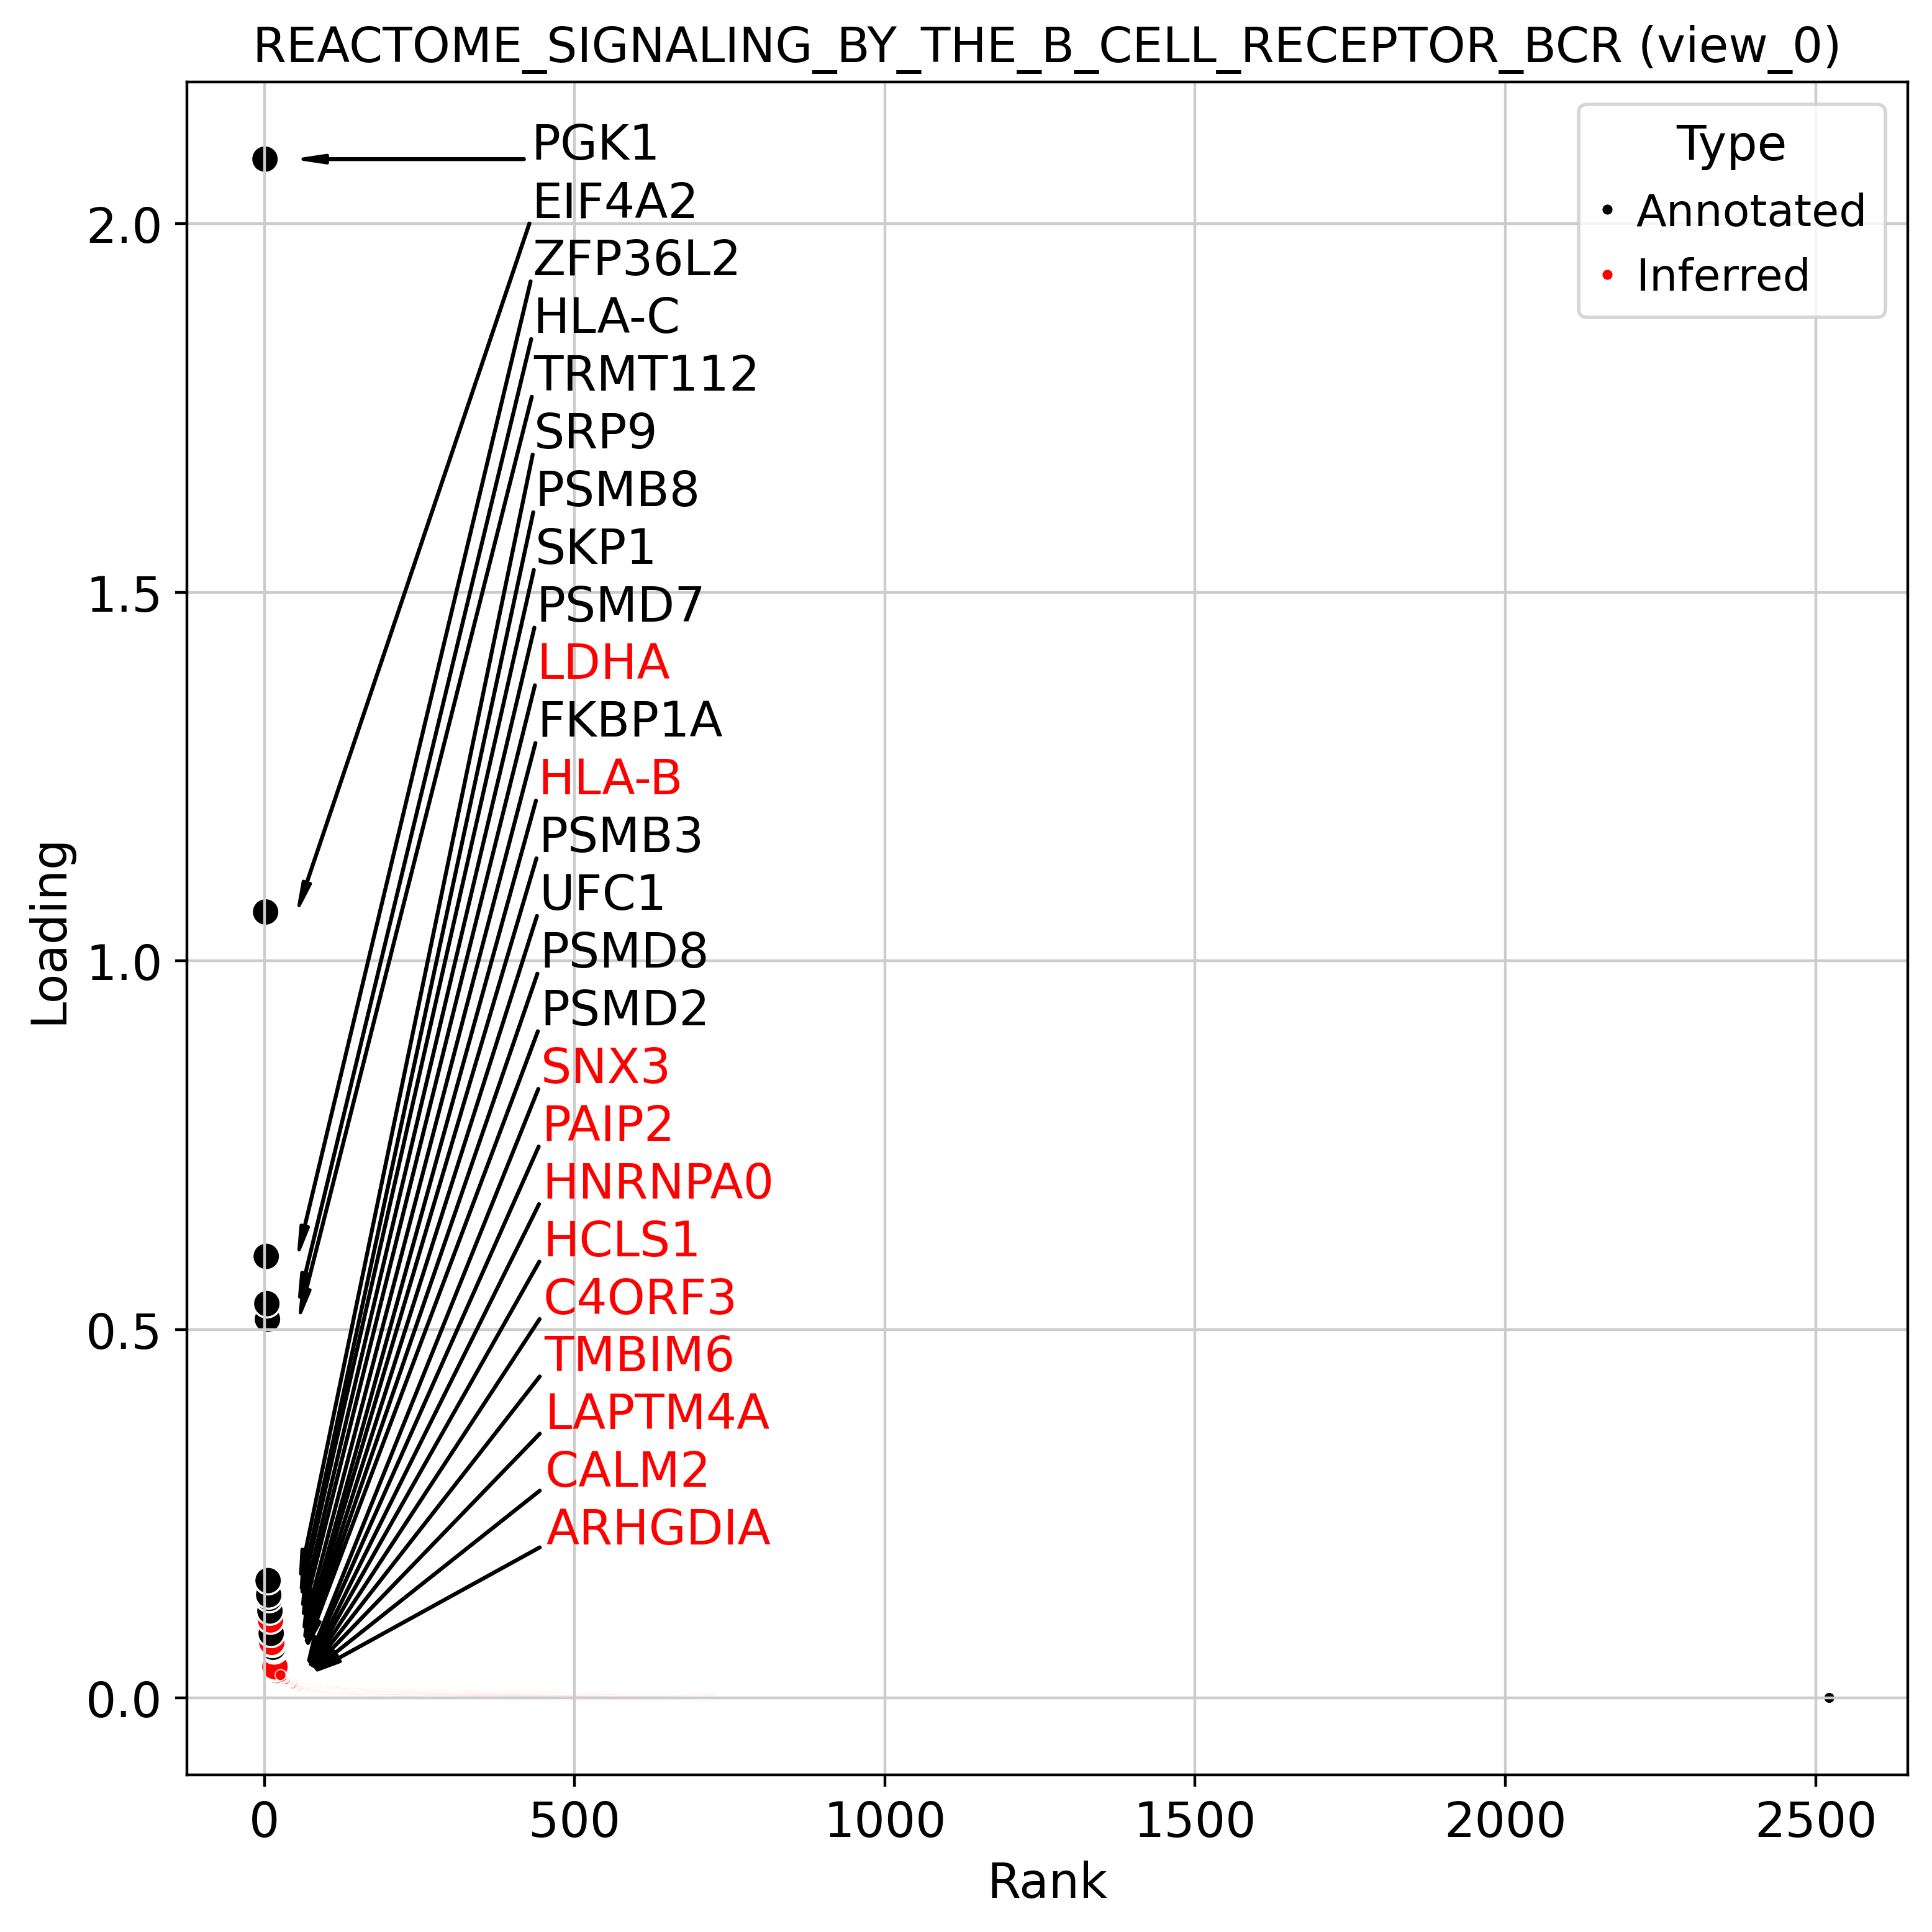

In [46]:
# plotting.plot_top_weights(model, "view_0", factor=4, nfeatures=10)
plotting.plot_top_weights(
    model,
    "REACTOME_SIGNALING_BY_THE_B_CELL_RECEPTOR_BCR",
    view_idx="all",
    top=25,
    ranked=True,
)